# preliminary EDA

- special tokens
- dialogue, summary, topic length
- summary ratio
- (bart tokenizer) tokenized summary ratio

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import os
import re
import json
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
import torch
# import pytorch_lightning as pl
from rouge import Rouge # 모델의 성능을 평가하기 위한 라이브러리입니다.

from torch.utils.data import Dataset , DataLoader
from transformers import AutoTokenizer, BartForConditionalGeneration, BartConfig
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

import wandb # 모델 학습 과정을 손쉽게 Tracking하고, 시각화할 수 있는 라이브러리입니다.

In [2]:
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")

In [3]:
# import matplotlib.font_manager as fm

# fe = fm.FontEntry(
#     fname=r'/root/nanum-gothic/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
#     name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
# fm.fontManager.addfont(r'/root/nanum-gothic/NanumGothic.ttf')
# fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
# plt.rcParams.update({
#     'font.size': 10, 
#     'font.family': 'NanumGothic'
#     }) # 폰트 설정

In [4]:
# config 설정에 tokenizer 모듈이 사용되므로 미리 tokenizer를 정의해줍니다.
tokenizer = AutoTokenizer.from_pretrained("digit82/kobart-summarization")

In [80]:
vocab = tokenizer.vocab

In [81]:
vocab

{'▁선도': 20138,
 '渋': 5181,
 '▁찾은': 19382,
 '}': 324,
 '鏑': 8273,
 'ჲ': 1206,
 '隧': 8450,
 '祛': 6147,
 '躪': 7824,
 '톄': 13219,
 'H-)': 203,
 '공을': 20021,
 '▁봤다.\n': 24056,
 '▁둔화': 28770,
 '▁있어서': 16269,
 '▁역을': 22710,
 '▁분들': 24955,
 '▁나가고': 28871,
 '繃': 6579,
 '쾻': 13007,
 '챴': 12651,
 '梳': 4709,
 '▁33': 18190,
 '▁나서는': 22290,
 '▁공화': 19199,
 '牽': 5584,
 '론과': 28748,
 '慝': 4001,
 '璜': 5782,
 '淳': 5171,
 '▁의원들은': 26035,
 '▁만루': 27811,
 'c)': 28152,
 '룹': 10405,
 '넬': 9571,
 '옹': 11857,
 '명박': 16589,
 '▁시작한': 17215,
 '酎': 8111,
 '퀠': 13048,
 '▁감소한': 25572,
 '▁경제정보': 29499,
 '羞': 6677,
 '懽': 4057,
 '碣': 6093,
 '卹': 2735,
 '塡': 3129,
 '엩': 11801,
 'լ': 814,
 '▁이렇': 20959,
 '侯': 2317,
 '拉': 4146,
 '竺': 6303,
 '▁삼성전자는': 21651,
 '▁시너지': 26509,
 '▁끝': 14539,
 '▁서민': 18118,
 '홑': 13712,
 '▁기분': 19720,
 '顾': 8619,
 '▁강원': 16329,
 '我': 4066,
 '▁때로는': 23401,
 '▁사이의': 19318,
 '취업': 25932,
 '▁7일': 16538,
 '▁나이에': 25970,
 '▁일할': 28172,
 '▁영향': 14849,
 '兄': 2470,
 '▁무죄': 21562,
 'Æ': 380,
 '▁국정조사': 25

In [6]:
len(vocab)

30000

### Load Data

In [5]:
data_path = "/root/data_original"

In [7]:
train_df = pd.read_csv(os.path.join(data_path,'train.csv'))
dev_df = pd.read_csv(os.path.join(data_path,'dev.csv'))
test_df = pd.read_csv(os.path.join(data_path,'test.csv'))

### EDA

#### train data 

In [8]:
train_df["dialogue_original_len"] = train_df["dialogue"].apply(lambda x : len(x))
train_df["summary_original_len"] = train_df["summary"].apply(lambda x : len(x))
train_df["topic_original_len"] = train_df["topic"].apply(lambda x : len(x))

In [9]:
train_df["topic"] = train_df["topic"].apply(lambda x: x.strip())
train_df["dialogue"] = train_df["dialogue"].apply(lambda x: x.strip())
train_df["summary"] = train_df["summary"].apply(lambda x: x.strip())

In [10]:
train_df["dialogue_len"] = train_df["dialogue"].apply(lambda x : len(x))
train_df["summary_len"] = train_df["summary"].apply(lambda x : len(x))
train_df["topic_len"] = train_df["topic"].apply(lambda x : len(x))

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   fname                  12457 non-null  object
 1   dialogue               12457 non-null  object
 2   summary                12457 non-null  object
 3   topic                  12457 non-null  object
 4   dialogue_original_len  12457 non-null  int64 
 5   summary_original_len   12457 non-null  int64 
 6   topic_original_len     12457 non-null  int64 
 7   dialogue_len           12457 non-null  int64 
 8   summary_len            12457 non-null  int64 
 9   topic_len              12457 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 973.3+ KB


In [12]:
train_df.describe().round(2)

,dialogue_original_len,summary_original_len,topic_original_len,dialogue_len,summary_len,topic_len
count,12457.00,12457.00,12457.00,12457.00,12457.00,12457.00
mean,438.77,87.40,5.10,438.73,87.39,5.09
std,220.13,37.64,2.85,220.13,37.64,2.73
min,99.00,19.00,1.00,99.00,19.00,1.00
25%,299.00,61.00,3.00,299.00,61.00,3.00
50%,396.00,80.00,5.00,396.00,80.00,5.00
75%,540.00,106.00,6.00,540.00,106.00,6.00
max,2546.00,478.00,118.00,2546.00,478.00,118.00


##### special tokens

In [13]:
import re

pattern = r'#[a-zA-Z]+\d*#'

special_tokens = set()

for index, row in train_df.iterrows():
    special_tokens_inrow = set(re.findall(pattern, row["dialogue"]))
    special_tokens.update(special_tokens_inrow)
    
for index, row in dev_df.iterrows():
    special_tokens_inrow = set(re.findall(pattern, row["dialogue"]))
    special_tokens.update(special_tokens_inrow)
    
for index, row in test_df.iterrows():
    special_tokens_inrow = set(re.findall(pattern, row["dialogue"]))
    special_tokens.update(special_tokens_inrow)   

In [14]:
special_tokens

{'#Address#',
 '#CarNumber#',
 '#CardNumber#',
 '#DateOfBirth#',
 '#Email#',
 '#PassportNumber#',
 '#Person#',
 '#Person1#',
 '#Person2#',
 '#Person3#',
 '#Person4#',
 '#Person5#',
 '#Person6#',
 '#Person7#',
 '#PhoneNumber#',
 '#SSN#'}

In [15]:
special_tokens_list = list(special_tokens)

In [16]:
len(special_tokens)

16

In [17]:
tokenizer.add_tokens(list(special_tokens))
vocab = tokenizer.vocab
len(vocab)

30016

In [18]:
train_df['special_tokens_d'] = train_df['dialogue'].apply(lambda x: re.findall(pattern, x))
train_df['special_tokens_d_len'] = train_df['special_tokens_d'].apply(lambda x: len(x))
train_df['special_tokens_d_uni'] = train_df['special_tokens_d'].apply(lambda x: list(set(x)))
train_df['special_tokens_d_uni_len'] = train_df['special_tokens_d_uni'].apply(lambda x : len(x))

train_df['special_tokens_s'] = train_df['summary'].apply(lambda x: re.findall(pattern, x))
train_df['special_tokens_s_len'] = train_df['special_tokens_s'].apply(lambda x: len(x))
train_df['special_tokens_s_uni'] = train_df['special_tokens_s'].apply(lambda x: list(set(x)))
train_df['special_tokens_s_uni_len'] = train_df['special_tokens_s_uni'].apply(lambda x : len(x))

In [19]:
pd.DataFrame(train_df['special_tokens_d_uni_len'].value_counts().sort_index())

,count
special_tokens_d_uni_len,
2,12151
3,270
4,26
5,8
6,1
7,1


In [20]:
train_df[train_df['special_tokens_d_uni_len'] >= 5].index

Index([190, 1574, 1623, 2906, 5702, 6090, 6552, 7709, 11085, 11765], dtype='int64')

Text(0.5, 1.0, 'Nunique of Special Tokens in Train Dialogue')

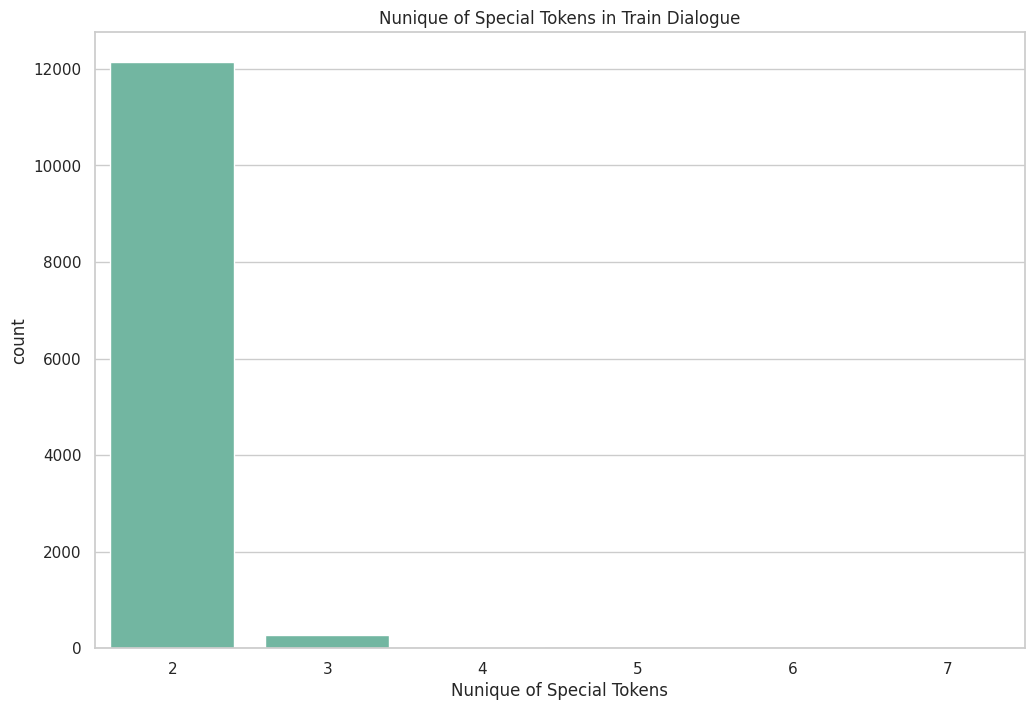

In [21]:
plt.figure(figsize=(12,8))
sns.countplot(data = train_df, x = 'special_tokens_d_uni_len')
plt.xlabel("Nunique of Special Tokens")
plt.title("Nunique of Special Tokens in Train Dialogue")

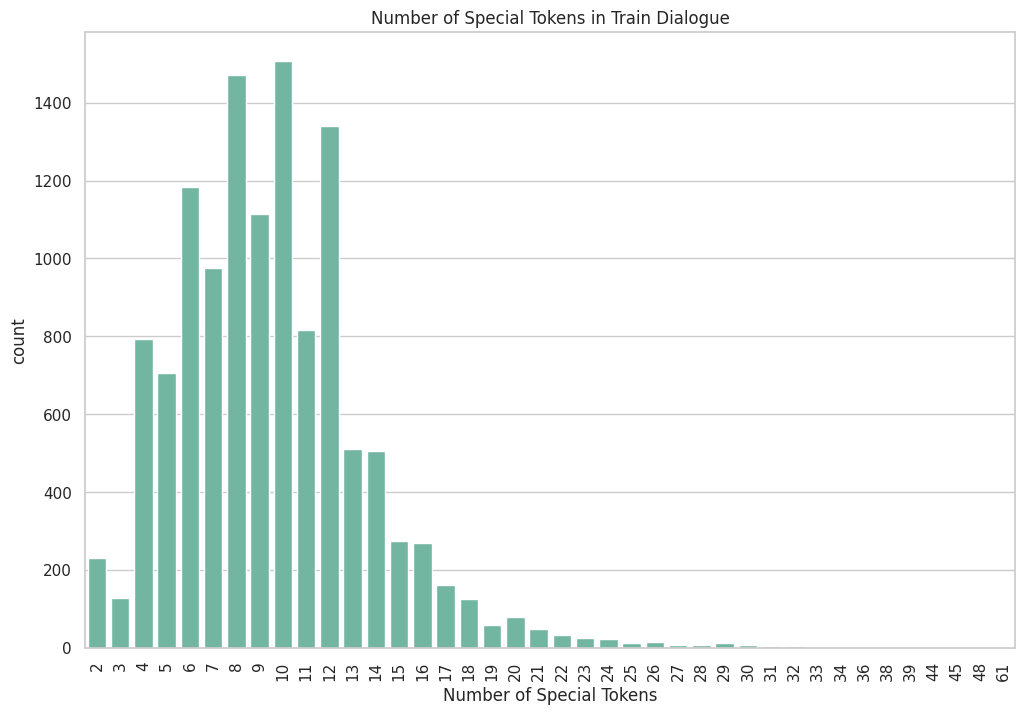

In [22]:
plt.figure(figsize=(12,8))
sns.countplot(data = train_df, x = 'special_tokens_d_len')
plt.xlabel("Number of Special Tokens")
plt.title("Number of Special Tokens in Train Dialogue")
plt.xticks(rotation=90)
plt.show()

In [23]:
train_df[train_df['special_tokens_d_uni_len'] == 7]

,fname,dialogue,summary,topic,dialogue_original_len,summary_original_len,topic_original_len,dialogue_len,summary_len,topic_len,special_tokens_d,special_tokens_d_len,special_tokens_d_uni,special_tokens_d_uni_len,special_tokens_s,special_tokens_s_len,special_tokens_s_uni,special_tokens_s_uni_len
11765,train_11768,#Person1#: 미래로의 여권인 스페이스 라디오 극장에 오신 것을 환영합니다. ...,#Person1#은 별선 내에서의 행동을 시작합니다. #Person2#는 대장이고 ...,라디오 연극,1339,281,6,1339,281,6,"[#Person1#, #Person2#, #Person3#, #Person2#, #...",24,"[#Person6#, #Person5#, #Person2#, #Person7#, #...",7,"[#Person1#, #Person2#, #Person3#, #Person4#, #...",9,"[#Person6#, #Person2#, #Person7#, #Person3#, #...",6


In [24]:
train_df.loc[11765, "special_tokens_d_uni"]

['#Person6#',
 '#Person5#',
 '#Person2#',
 '#Person7#',
 '#Person3#',
 '#Person4#',
 '#Person1#']

In [25]:
display(train_df.loc[11765, "dialogue"])

'#Person1#: 미래로의 여권인 스페이스 라디오 극장에 오신 것을 환영합니다. 이 에피소드에서는, 승무원들이 알 수 없는 공격에 노출되어 있습니다. 이 에피소드는 스타쉽 퀘스트에 탑승한 승무원들로 시작합니다.\n#Person2#: 상태 보고해, 커맨더 크르도비.\n#Person3#: . 항로는 깨끗해 보이는데, 대장님...\n#Person2#: 네, 커맨더?\n#Person1#: 갑자기 대장은 크르도비 씨가 다리에서 사라진 것을 깨닫습니다.\n#Person2#: 커맨더? 컴퓨터... 커맨더 크르도비의 위치를 찾아줘.\n#Person4#: 크르도비 씨는 이 배에 없습니다.\n#Person2#: 컴퓨터... (비프 비프). 그가 배를 떠난 직후 1분 전부터 1분 후까지의 배의 상태는 어땠나?\n#Person4#: 알 수 없는 외계인들이 배의 시스템에 접속했습니다. 외계인들은 전송 시스템을 통해 전기 충격을 보냈습니다.\n#Person2#: 다리에서 전송실로... 부관님, 응답해주세요. 보안, 즉시 전송실로 와서 조사해주세요.\n#Person1#: 보안관들, 부관 모르티아 아담스와 이등병 그렉 스즈키는 전송실로 달려갔습니다. 이제, 우리는 전송실로 이동합니다.\n#Person5#: 모르티아? 이걸 봐!\n#Person6#: 어머. 대장님이 이걸 좋아하진 않을 거야.\n#Person1#: 이제, 다시 다리로...\n#Person6#: 대장님? 컴퓨터... (비프 비프). 대장 듀로셋의 위치를 찾아줘.\n#Person4#: 대장 멜로니 듀로셋은 이 배에 없습니다.\n#Person6#: 그린필드 씨, 루토 씨, 다리를 맡아주시고 무슨 일이 있으면 알려주세요. 모르티아가 모든 데크에 보고하겠습니다. 화물함 3으로 모여주세요.\n#Person1#: 몇 분 후, 커맨더 모르티아가 지휘를 맡고 화물함 3에서 승무원들에게 브리핑을 하고 있습니다.\n#Person6#: 여러분들이 알고 계시듯이, 20명의 승무원들이 배에서 사라졌습니다. 우리의 센서는 공간 플럭스를 감지했습니다

In [26]:
train_df.loc[11765, "summary"]

'#Person1#은 별선 내에서의 행동을 시작합니다. #Person2#는 대장이고 #Person3#는 나중에 사라지는 커맨더입니다. #Person4#는 전송 시스템을 통해 외계인을 감지하고 #Person2#는 보안관들이 전송실로 보고하라고 명령합니다. 그런 다음 #Person6#는 대장이 선상에 없다는 것을 발견하고 커맨더로서 지휘를 맡습니다. #Person6#는 20명의 승무원들이 사라졌다고 브리핑하고 그런 다음 #Person7#는 #Person6#에게 다가오는 다섯 대의 외계인 함선을 알립니다.'

In [27]:
pd.DataFrame(train_df['special_tokens_s_uni_len'].value_counts().sort_index())

,count
special_tokens_s_uni_len,
0,1456
1,3000
2,7965
3,34
4,1
6,1


In [28]:
pd.DataFrame(train_df['special_tokens_s_len'].value_counts().sort_index())

,count
special_tokens_s_len,
0,1456
1,1882
2,4061
3,2612
4,1454
5,592
6,249
7,98
8,30


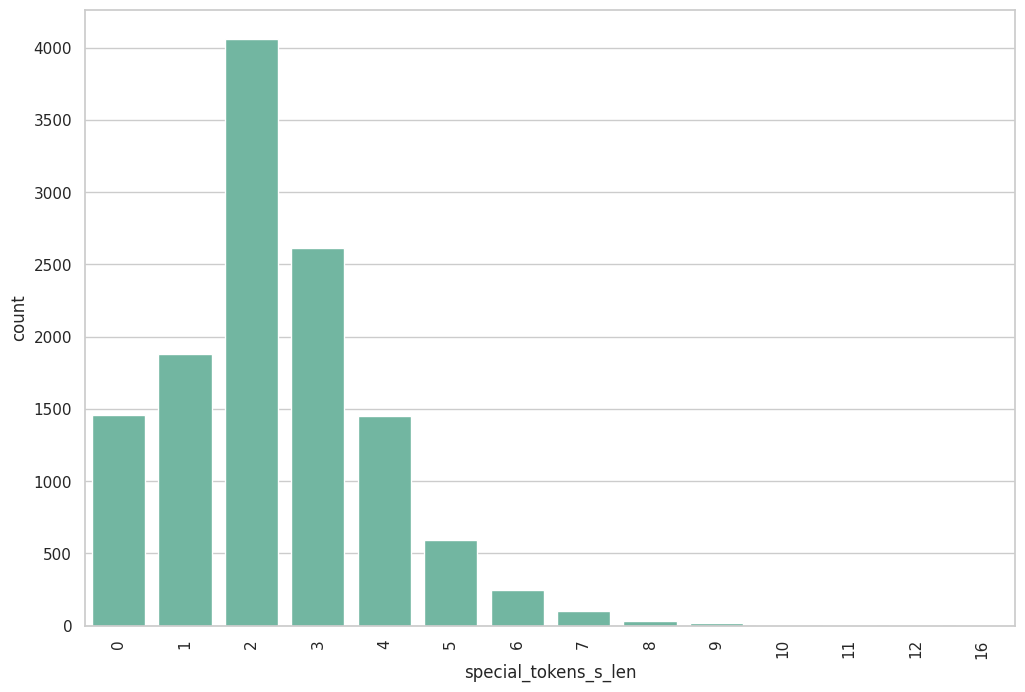

In [29]:
plt.figure(figsize=(12,8))
sns.countplot(data = train_df, x = 'special_tokens_s_len')
plt.xticks(rotation=90)
plt.show()

In [30]:
len(train_df[train_df['special_tokens_d_uni_len'] > 2])

306

In [31]:
train_df['special_tokens_d']

0        [#Person1#, #Person2#, #Person1#, #Person2#, #...
1        [#Person1#, #Person2#, #Person1#, #Person2#, #...
2        [#Person1#, #Person2#, #Person1#, #Person2#, #...
3        [#Person1#, #Person2#, #Person1#, #Person2#, #...
4        [#Person1#, #Person2#, #Person1#, #Person2#, #...
                               ...                        
12452    [#Person1#, #Person2#, #Person1#, #Person2#, #...
12453         [#Person1#, #Person2#, #Person1#, #Person2#]
12454    [#Person1#, #Person2#, #Person1#, #Person2#, #...
12455    [#Person1#, #Person2#, #Person1#, #Person2#, #...
12456    [#Person1#, #Person2#, #Person1#, #Person2#, #...
Name: special_tokens_d, Length: 12457, dtype: object

In [32]:
train_df['special_tokens_s']

0                                                  []
1                                                  []
2                              [#Person1#, #Person2#]
3                   [#Person1#, #Person2#, #Person1#]
4                                                  []
                             ...                     
12452                                              []
12453                          [#Person1#, #Person2#]
12454                          [#Person2#, #Person1#]
12455    [#Person2#, #Person2#, #Person1#, #Person2#]
12456                          [#Person1#, #Person2#]
Name: special_tokens_s, Length: 12457, dtype: object

##### summary ratio

In [33]:
train_df["summary_ratio"] = train_df["summary_len"].astype(int)/train_df["dialogue_len"].astype(int)

In [34]:
pd.DataFrame(train_df["summary_ratio"].describe())

,summary_ratio
count,12457.000000
mean,0.214737
std,0.069922
min,0.048780
25%,0.168342
50%,0.204724
75%,0.248980
max,0.864865


Text(0.5, 1.0, 'Summary Ratio of Train Data (before tokenizing)')

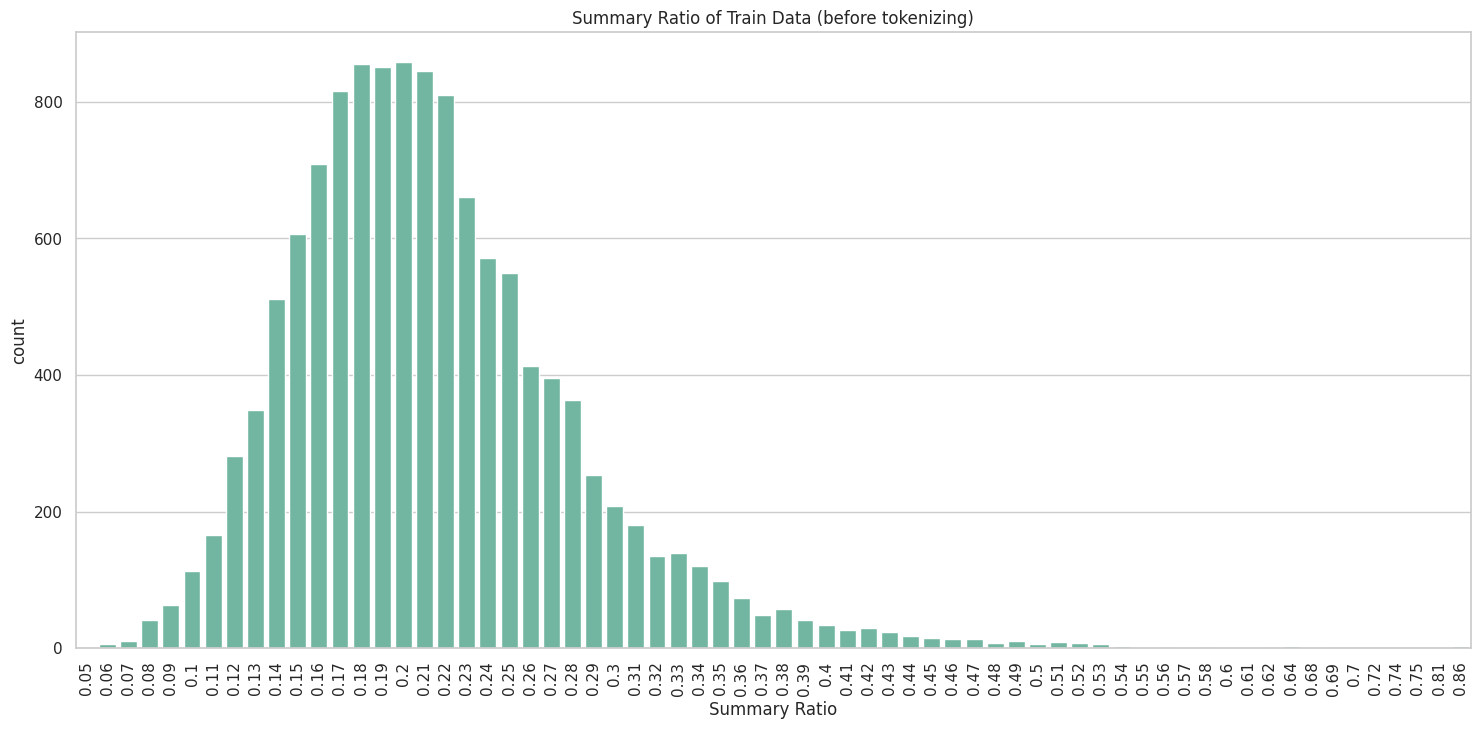

In [35]:
plt.figure(figsize=(18,8))
sns.countplot(data = train_df, x = train_df["summary_ratio"].round(2))
plt.xlabel("Summary Ratio")
plt.xticks(rotation=90)
plt.title("Summary Ratio of Train Data (before tokenizing)")

In [36]:
len(train_df[train_df["summary_ratio"] > 0.25])

3039

In [37]:
len(train_df[train_df["summary_ratio"] > 0.5])

54

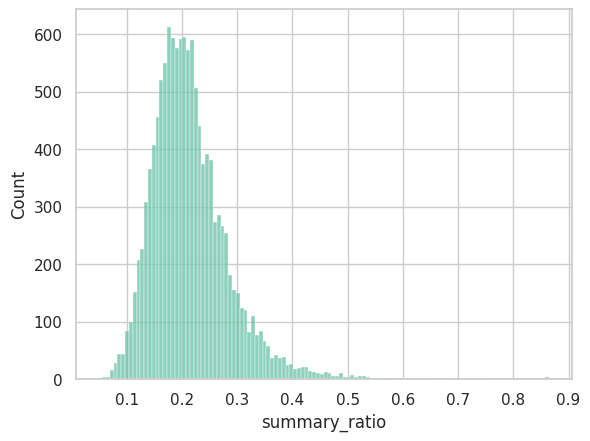

In [38]:
sns.histplot(train_df["summary_ratio"])
plt.show()

In [39]:
len(train_df[train_df["summary_ratio"] > 0.5])

54

In [40]:
train_df[train_df["summary_ratio"] > 0.5].index

Index([  130,   314,   858,   971,  1041,  1042,  1094,  1168,  1349,  1416,
        1481,  1755,  1922,  1972,  3192,  3895,  3940,  3956,  4709,  4852,
        4980,  5262,  5332,  5693,  5697,  6182,  6318,  6751,  6798,  7079,
        7180,  7321,  7528,  7600,  7906,  8023,  8306,  8818,  8931,  9408,
        9500,  9551,  9552, 10227, 10241, 10816, 10905, 11147, 11174, 11343,
       11383, 11441, 11697, 11771],
      dtype='int64')

##### dialogue

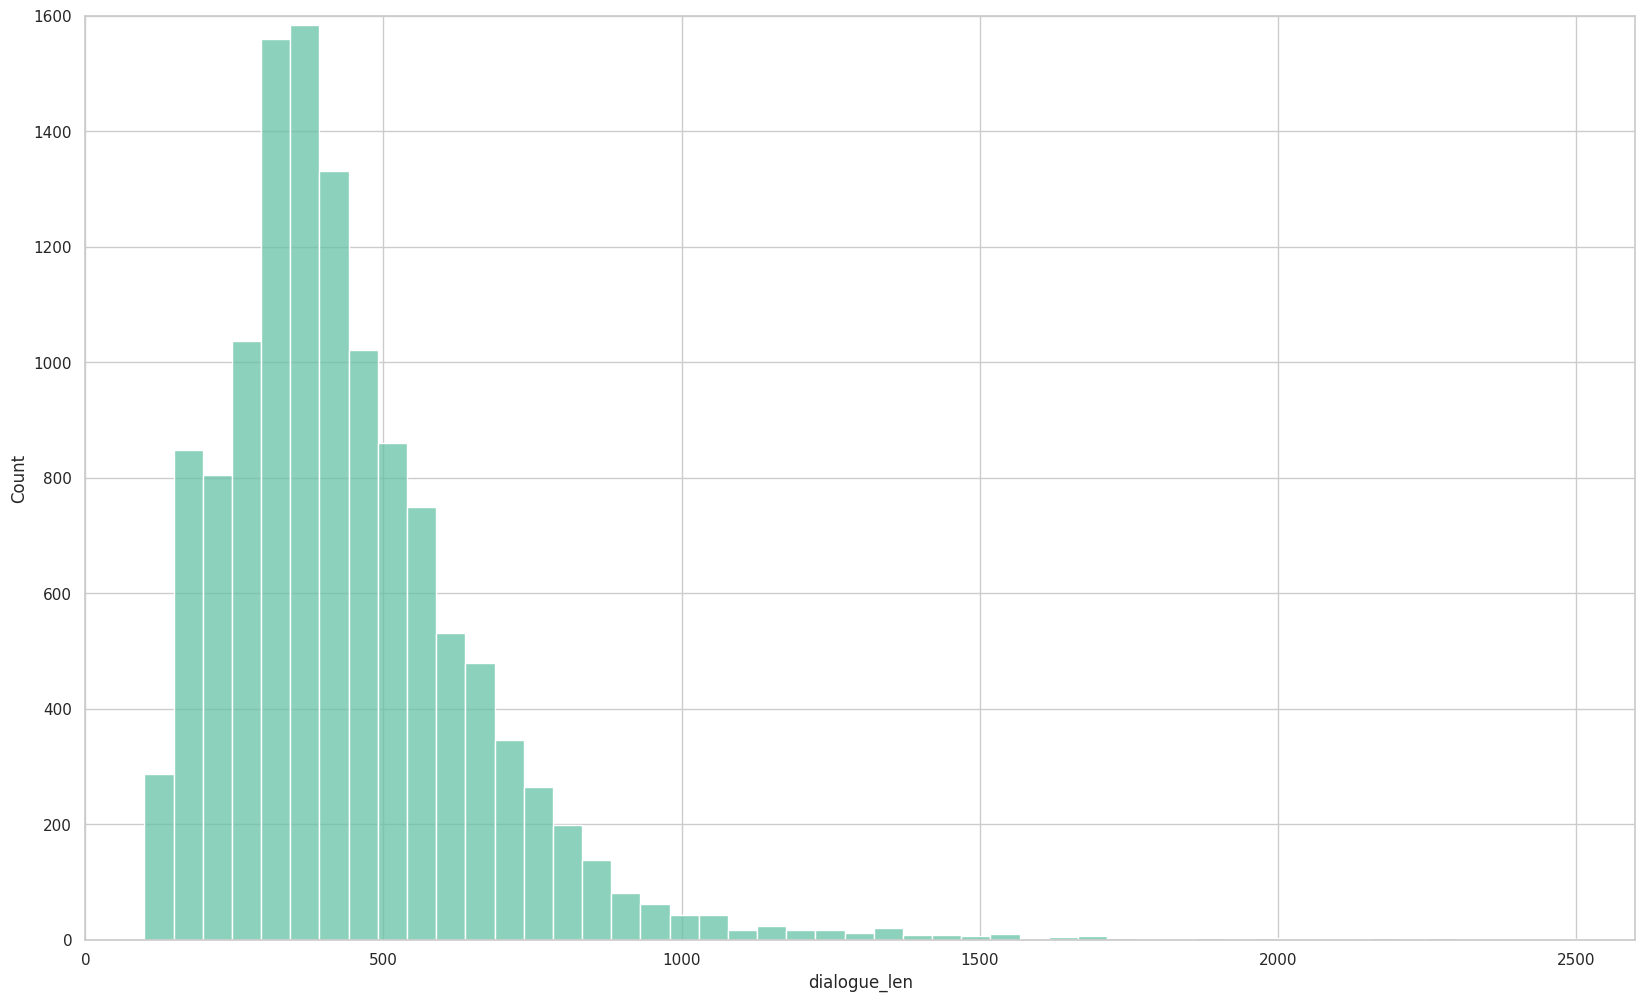

In [41]:
plt.figure(figsize=(20, 12))
sns.histplot(data = train_df, x = train_df["dialogue_len"], bins=50)
plt.xlim(0, 2600)
plt.ylim(0, 1600)
plt.show()

In [42]:
pd.DataFrame(train_df["dialogue_len"].describe().round(2))

,dialogue_len
count,12457.00
mean,438.73
std,220.13
min,99.00
25%,299.00
50%,396.00
75%,540.00
max,2546.00


In [43]:
len(train_df[train_df["dialogue_original_len"] != train_df["dialogue_len"]])

425

In [44]:
len(train_df[(train_df["dialogue_original_len"] - train_df["dialogue_len"]) == 1])

422

In [45]:
len(train_df[(train_df["dialogue_original_len"] - train_df["dialogue_len"]) == 2])

3

In [46]:
len(train_df[(train_df["dialogue_original_len"] == train_df["dialogue_len"])])

12032

##### summary

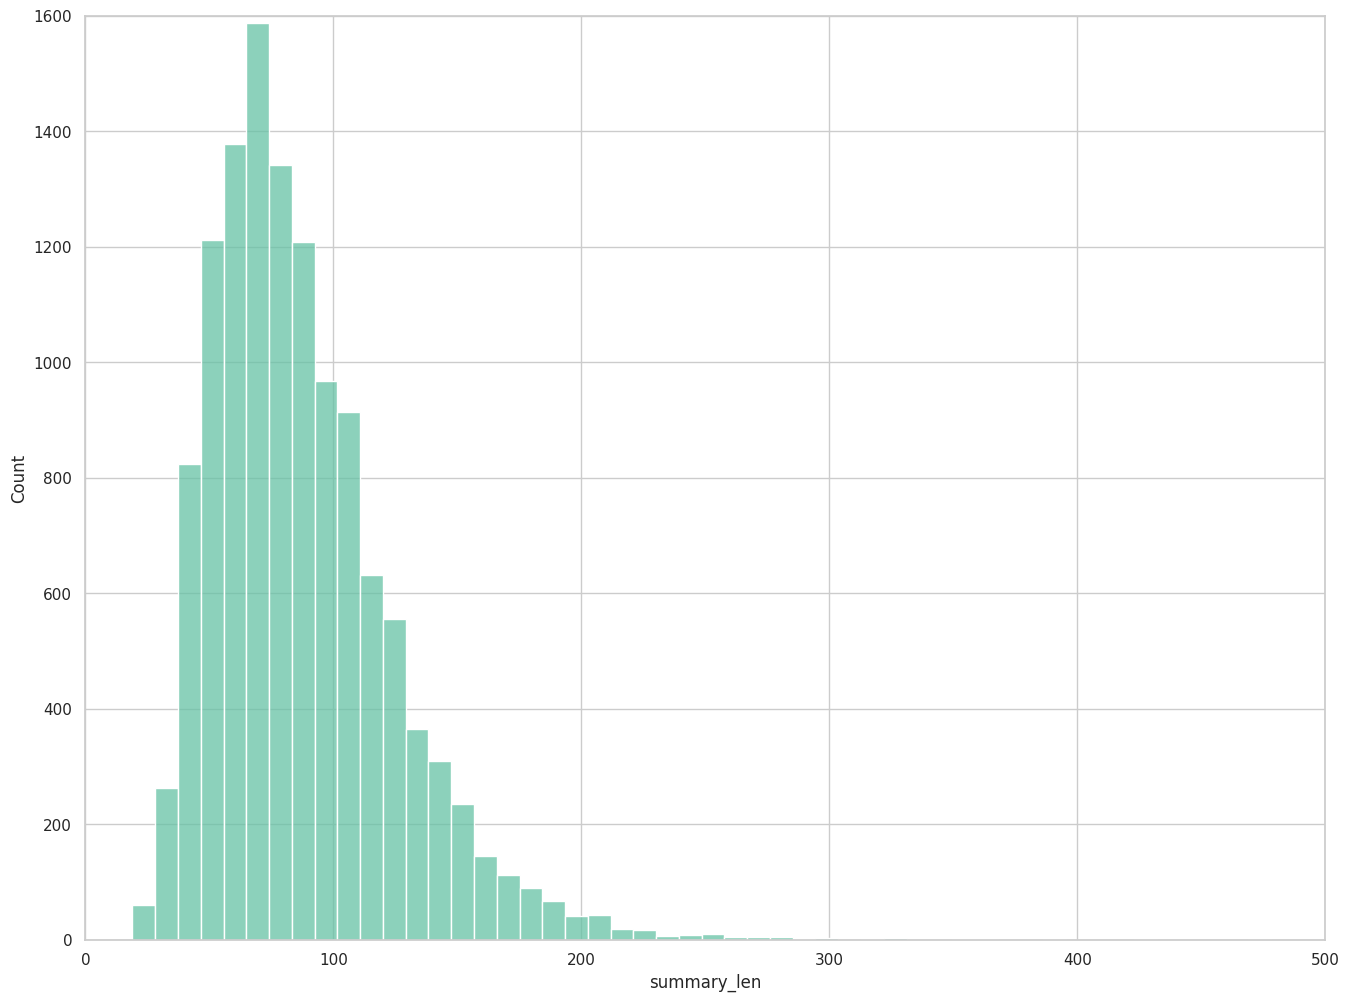

In [47]:
plt.figure(figsize=(16, 12))
sns.histplot(data = train_df, x = train_df["summary_len"], bins=50)
plt.xlim(0, 500)
plt.ylim(0, 1600)
plt.show()

In [48]:
pd.DataFrame(train_df["summary_len"].describe().round(2))

,summary_len
count,12457.00
mean,87.39
std,37.64
min,19.00
25%,61.00
50%,80.00
75%,106.00
max,478.00


In [49]:
len(train_df[train_df["summary_original_len"] != train_df["summary_len"]])

104

In [50]:
len(train_df[(train_df["summary_original_len"] - train_df["summary_len"]) == 1])

103

In [51]:
len(train_df[(train_df["summary_original_len"] - train_df["summary_len"]) == 2])

1

In [52]:
train_df[(train_df["summary_original_len"] - train_df["summary_len"]) > 1]

,fname,dialogue,summary,topic,dialogue_original_len,summary_original_len,topic_original_len,dialogue_len,summary_len,topic_len,special_tokens_d,special_tokens_d_len,special_tokens_d_uni,special_tokens_d_uni_len,special_tokens_s,special_tokens_s_len,special_tokens_s_uni,special_tokens_s_uni_len,summary_ratio
10716,train_10716,"#Person1#: 톰, 너 시험 몇 번 있어?\n#Person2#: 세 개야, 이...","#Person1#은 시험을 선호하는 반면, 톰은 논문을 더 좋아한다. 그리고 톰은 ...",학교,415,67,2,415,65,2,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",10,"[#Person2#, #Person1#]",2,[#Person1#],1,[#Person1#],1,0.156627


##### topic

In [53]:
len(train_df[train_df["topic_original_len"] != train_df["topic_len"]])

51

In [54]:
len(train_df[(train_df["topic_original_len"] - train_df["topic_len"]) == 1])

44

In [55]:
len(train_df[(train_df["topic_original_len"] - train_df["topic_len"]) == 2])

6

In [56]:
len(train_df[(train_df["topic_original_len"] - train_df["topic_len"]) > 2])

1

In [57]:
train_df[(train_df["topic_original_len"] - train_df["topic_len"]) > 2]

,fname,dialogue,summary,topic,dialogue_original_len,summary_original_len,topic_original_len,dialogue_len,summary_len,topic_len,special_tokens_d,special_tokens_d_len,special_tokens_d_uni,special_tokens_d_uni_len,special_tokens_s,special_tokens_s_len,special_tokens_s_uni,special_tokens_s_uni_len,summary_ratio
4181,train_4181,#Person1#: 오늘은 그 노부부의 금혼식이에요.\n#Person2#: 정말 오...,#Person1#과 #Person2#가 노부부의 금혼식에 대해 이야기합니다.,오래가는 사랑,164,42,98,164,42,7,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",5,"[#Person2#, #Person1#]",2,"[#Person1#, #Person2#]",2,"[#Person2#, #Person1#]",2,0.256098


In [58]:
len(train_df[(train_df["topic_original_len"] - train_df["topic_len"]) > 1])

7

In [59]:
train_df[train_df["topic_len"] == 1]

,fname,dialogue,summary,topic,dialogue_original_len,summary_original_len,topic_original_len,dialogue_len,summary_len,topic_len,special_tokens_d,special_tokens_d_len,special_tokens_d_uni,special_tokens_d_uni_len,special_tokens_s,special_tokens_s_len,special_tokens_s_uni,special_tokens_s_uni_len,summary_ratio
25,train_25,"#Person1#: 이 모든 보안 검사는 무슨 일인가요, 지미? 이 바가 위험한 곳...",#Person1#이 처음으로 바에 왔습니다. #Person1#은 세련된 인테리어를 ...,바,661,96,1,661,96,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",11,"[#Person2#, #Person1#]",2,"[#Person1#, #Person1#, #Person1#]",3,[#Person1#],1,0.145234
105,train_105,#Person1#: 어떤 춤을 좋아하나요?\n#Person2#: 저는 빠른 음악에 ...,#Person2#는 디스코를 좋아하므로 #Person1#과 #Person2#는 디스...,춤,299,77,1,299,77,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",10,"[#Person2#, #Person1#]",2,"[#Person2#, #Person1#, #Person2#]",3,"[#Person2#, #Person1#]",2,0.257525
662,train_662,"#Person1#: 안녕! 만나서 반가워, 낸시! 어제 어디 있었어?\n#Perso...",낸시는 #Person1#에게 어제 아파서 못 왔다고 말한다. #Person1#은 낸...,병,251,59,1,251,59,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",8,"[#Person2#, #Person1#]",2,"[#Person1#, #Person1#]",2,[#Person1#],1,0.235060
711,train_711,"#Person1#: 안녕하세요, 방금 광고를 봤습니다. 아직 빌려주지 않으셨나요?\...",왕리가 방을 임대하려고 한다. 수잔 프라이스와 그녀는 결국 주당 임대료를 40달러로...,방,731,72,1,731,72,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",17,"[#Person2#, #Person1#]",2,[],0,[],0,0.098495
718,train_718,"#Person1#: 헤이, 집을 보여드릴게요. 음, 여기가 거실이에요.\n#Pers...","#Person1#이 집을 #Person2#에게 보여주고, #Person2#는 나쁜 ...",집,343,59,1,343,59,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",8,"[#Person2#, #Person1#]",2,"[#Person1#, #Person2#, #Person2#]",3,"[#Person2#, #Person1#]",2,0.172012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11833,train_11836,#Person1#: 저는 중국 사람들이 차를 마시는 것을 정말 즐기는 것 같다는 것...,"#Person1#과 #Person2#는 중국 차의 다양한 종류에 대해 이야기하며, ...",차,293,76,1,293,76,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",6,"[#Person2#, #Person1#]",2,"[#Person1#, #Person2#]",2,"[#Person2#, #Person1#]",2,0.259386
11922,train_11925,#Person1#: 두 개의 침대가 있는 방을 원합니다. \n#Person2#: 더...,#Person1#와 #Person3#는 #Person2#의 도움으로 14층에 있는 ...,방,507,117,1,507,117,1,"[#Person1#, #Person2#, #Person3#, #Person1#, #...",7,"[#Person2#, #Person3#, #Person1#]",3,"[#Person1#, #Person3#, #Person2#, #Person3#, #...",6,"[#Person2#, #Person3#, #Person1#]",3,0.230769
12187,train_12190,"#Person1#: 바텐더가 마지막 주문을 받았어. 한 잔 더 시키자, 괜찮지?\n...",#Person1#과 #Person2#는 #Person2#가 맥주를 주문하고 #Per...,바,426,87,1,426,87,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",10,"[#Person2#, #Person1#]",2,"[#Person1#, #Person2#, #Person2#, #Person1#]",4,"[#Person2#, #Person1#]",2,0.204225
12374,train_12377,"#Person1#: 벨보이에게 팁을 주셨나요?\n#Person2#: 네, 그런데 충...",#Person2#는 벨보이에게 준 팁이 부족했다고 생각하고 택시 기사에게 준 팁은 ...,팁,578,94,1,578,94,1,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",7,"[#Person2#, #Person1#]",2,"[#Person2#, #Person1#]",2,"[#Person2#, #Person1#]",2,0.162630


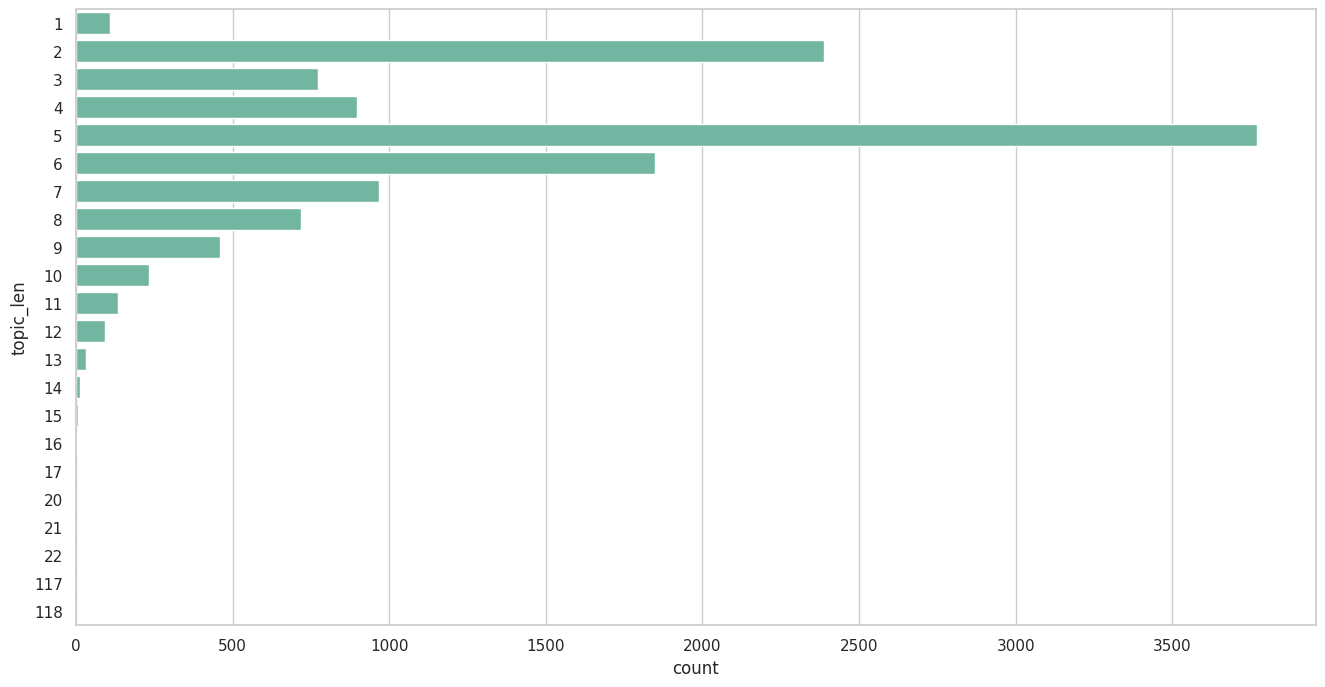

In [60]:
plt.figure(figsize=(16, 8))
sns.countplot(data = train_df, y = train_df["topic_len"])
plt.show()

In [61]:
train_df[train_df["topic_len"] == 118]

,fname,dialogue,summary,topic,dialogue_original_len,summary_original_len,topic_original_len,dialogue_len,summary_len,topic_len,special_tokens_d,special_tokens_d_len,special_tokens_d_uni,special_tokens_d_uni_len,special_tokens_s,special_tokens_s_len,special_tokens_s_uni,special_tokens_s_uni_len,summary_ratio
3804,train_3804,"#Person1#: 그린 씨, 미국 전역의 학교는 대체로 비슷한가요, 아니면 지역에...",그린 씨는 #Person1#에게 미국 대부분의 학생들은 공립학교에 다니며 특정 유형...,그린씨는 #Person1#에게 미국에서 대부분의 학생들이 공립학교에 다니며 특정 유...,602,111,118,602,111,118,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",10,"[#Person2#, #Person1#]",2,[#Person1#],1,[#Person1#],1,0.184385


In [62]:
train_df[train_df["topic_len"] == 117]

,fname,dialogue,summary,topic,dialogue_original_len,summary_original_len,topic_original_len,dialogue_len,summary_len,topic_len,special_tokens_d,special_tokens_d_len,special_tokens_d_uni,special_tokens_d_uni_len,special_tokens_s,special_tokens_s_len,special_tokens_s_uni,special_tokens_s_uni_len,summary_ratio
7595,train_7595,"#Person1#: 안녕, 나타샤, 어떻게 지내?\n#Person2#: 잘 지내. ...",나타샤는 #Person1#에게 그녀의 가족이 그녀를 보러 왔다고 말한다. 그 후 그...,나타샤는 #Person1#에게 그녀의 가족이 그녀를 보러 왔다고 말한다. 그 후 그...,621,117,117,621,117,117,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",13,"[#Person2#, #Person1#]",2,"[#Person1#, #Person1#]",2,[#Person1#],1,0.188406


In [63]:
train_df[train_df["topic_len"] == 22]

,fname,dialogue,summary,topic,dialogue_original_len,summary_original_len,topic_original_len,dialogue_len,summary_len,topic_len,special_tokens_d,special_tokens_d_len,special_tokens_d_uni,special_tokens_d_uni_len,special_tokens_s,special_tokens_s_len,special_tokens_s_uni,special_tokens_s_uni_len,summary_ratio
11846,train_11849,#Person1#: 어제 밤에 '메리에 관한 뭔가'를 봤어요. 정말 웃겼어요.\n#...,#Person1#은 어제 밤에 '메리에 관한 뭔가'를 봤습니다. #Person2#는...,메리에 관한 뭔가' 코미디에 대한 이야기,533,144,22,533,144,22,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",11,"[#Person2#, #Person1#]",2,"[#Person1#, #Person2#, #Person1#, #Person1#, #...",6,"[#Person2#, #Person1#]",2,0.270169


In [64]:
train_df[train_df["topic_len"] == 20]

,fname,dialogue,summary,topic,dialogue_original_len,summary_original_len,topic_original_len,dialogue_len,summary_len,topic_len,special_tokens_d,special_tokens_d_len,special_tokens_d_uni,special_tokens_d_uni_len,special_tokens_s,special_tokens_s_len,special_tokens_s_uni,special_tokens_s_uni_len,summary_ratio
2112,train_2112,"#Person1#: 드디어 금요일이네. 여보, 이번 주말에 재미있는 거 하자.\n#...","#Person1#은 이번 주말에 수영하거나, 산악 자전거를 타거나, 낚시를 제안합니...",재미있는 것을 하다재미있는 것을 하다,512,122,20,512,122,20,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",13,"[#Person2#, #Person1#]",2,"[#Person1#, #Person2#, #Person1#]",3,"[#Person2#, #Person1#]",2,0.238281


##### tokenize

In [65]:
train_df["dialogue_token"] = train_df["dialogue"].apply(lambda x : tokenizer(x)["input_ids"])
train_df["summary_token"] = train_df["summary"].apply(lambda x : tokenizer(x)["input_ids"])
train_df["dialogue_token_len"] = train_df["dialogue_token"].apply(lambda x : len(x))
train_df["summary_token_len"] = train_df["summary_token"].apply(lambda x : len(x))
train_df["summary_ratio_token"] = train_df["summary_token_len"] / train_df["dialogue_token_len"]

In [66]:
pd.DataFrame(train_df["summary_ratio_token"].sort_values(ascending=False)[:10])

,summary_ratio_token
1094,0.826923
7528,0.822222
5332,0.800000
4852,0.796610
9500,0.708333
858,0.697674
1481,0.638889
1041,0.638889
3192,0.615385
7600,0.613636


In [67]:
train_df["dialogue_token_len"].describe().round(2)

count    12457.00
mean       158.56
std         82.48
min         32.00
25%        105.00
50%        141.00
75%        197.00
max        950.00
Name: dialogue_token_len, dtype: float64

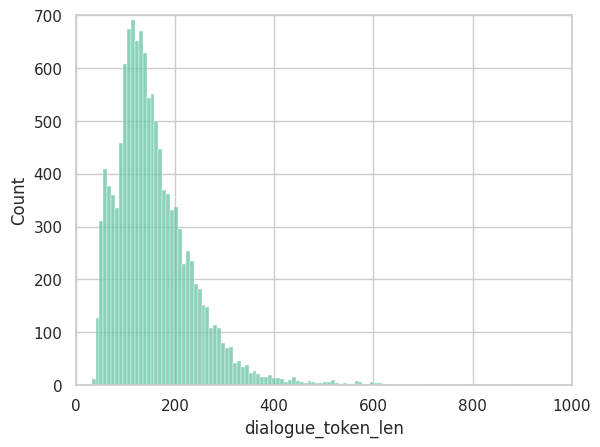

In [68]:
sns.histplot(data=train_df, x=train_df["dialogue_token_len"])
plt.xlim(0, 1000)
plt.ylim(0, 700)
plt.show()

In [69]:
train_df["summary_token_len"].describe().round(2)

count    12457.00
mean        30.97
std         13.64
min          7.00
25%         21.00
50%         29.00
75%         38.00
max        165.00
Name: summary_token_len, dtype: float64

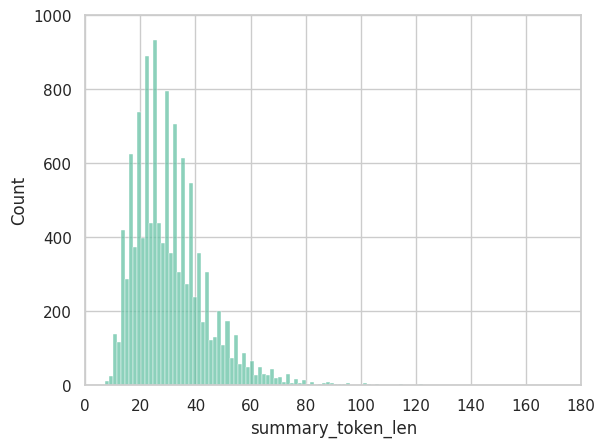

In [70]:
sns.histplot(data=train_df, x=train_df["summary_token_len"])
plt.xlim(0, 180)
plt.ylim(0, 1000)
plt.show()

In [71]:
train_df.columns

Index(['fname', 'dialogue', 'summary', 'topic', 'dialogue_original_len',
       'summary_original_len', 'topic_original_len', 'dialogue_len',
       'summary_len', 'topic_len', 'special_tokens_d', 'special_tokens_d_len',
       'special_tokens_d_uni', 'special_tokens_d_uni_len', 'special_tokens_s',
       'special_tokens_s_len', 'special_tokens_s_uni',
       'special_tokens_s_uni_len', 'summary_ratio', 'dialogue_token',
       'summary_token', 'dialogue_token_len', 'summary_token_len',
       'summary_ratio_token'],
      dtype='object')

In [72]:
pd.DataFrame(train_df["summary_ratio_token"].describe())

,summary_ratio_token
count,12457.000000
mean,0.210525
std,0.065519
min,0.053973
25%,0.167401
50%,0.201613
75%,0.242424
max,0.826923


Text(0.5, 1.0, 'Summary Ratio of Train Data (after tokenizing)')

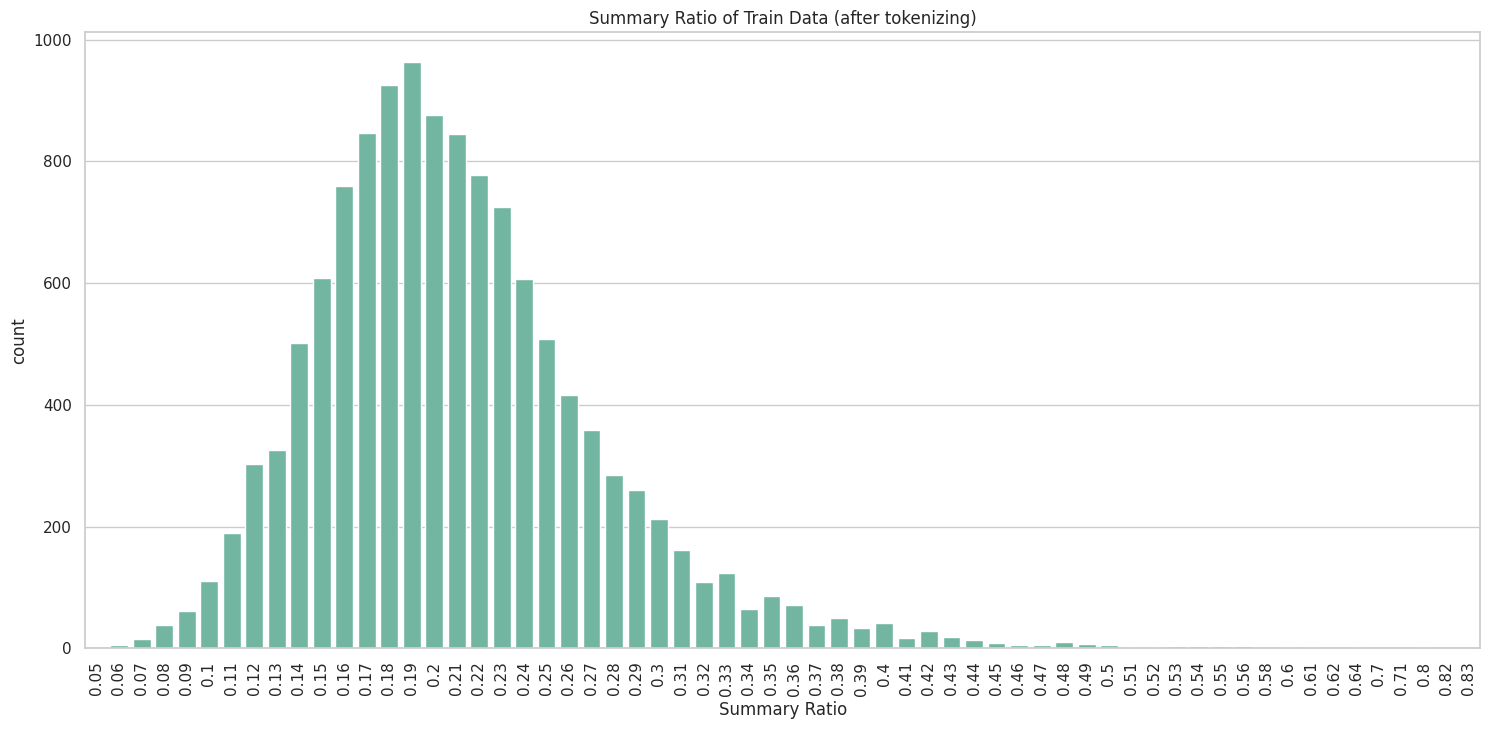

In [73]:
plt.figure(figsize=(18,8))
sns.countplot(data = train_df, x = train_df["summary_ratio_token"].round(2))
plt.xlabel("Summary Ratio")
plt.xticks(rotation=90)
plt.title("Summary Ratio of Train Data (after tokenizing)")

In [74]:
train_df[train_df["summary_ratio_token"] > 0.5].index

Index([  858,  1041,  1094,  1168,  1349,  1481,  1755,  1972,  3192,  3940,
        4846,  4852,  4980,  5262,  5332,  5693,  5697,  6288,  6318,  6798,
        7528,  7600,  7906,  8023,  8306,  8818,  8834,  9500,  9551,  9635,
       10203, 10227, 11441],
      dtype='int64')

In [75]:
len(train_df[train_df["summary_ratio_token"] > 0.5])

33

In [76]:
train_df["summary_ratio_token"].sort_values(ascending=False)[:10]

1094    0.826923
7528    0.822222
5332    0.800000
4852    0.796610
9500    0.708333
858     0.697674
1481    0.638889
1041    0.638889
3192    0.615385
7600    0.613636
Name: summary_ratio_token, dtype: float64

##### checking outliers

In [77]:
train_df[train_df["summary_ratio_token"] > 0.5]["summary_ratio_token"].sort_values(ascending=False)

1094     0.826923
7528     0.822222
5332     0.800000
4852     0.796610
9500     0.708333
858      0.697674
1481     0.638889
1041     0.638889
3192     0.615385
7600     0.613636
1349     0.605634
6318     0.604167
5697     0.595238
9551     0.578947
7906     0.564516
8834     0.562500
4980     0.562500
8818     0.557377
5262     0.553191
1755     0.547619
11441    0.547170
5693     0.545455
10227    0.540984
1972     0.540541
3940     0.540000
8023     0.537037
4846     0.530612
8306     0.530120
6288     0.526316
10203    0.523077
6798     0.522727
1168     0.510638
9635     0.507042
Name: summary_ratio_token, dtype: float64

##### checking outliers(1) : summary ratio top 10

In [78]:
train_df["summary_ratio"].sort_values(ascending=False)[:10]

858     0.864865
5332    0.860656
1094    0.859259
7528    0.805970
1041    0.747573
4852    0.737705
9500    0.723404
1481    0.699029
9551    0.690000
5697    0.684211
Name: summary_ratio, dtype: float64

In [79]:
train_df["summary_ratio"].sort_values(ascending=False)[:10].index

Index([858, 5332, 1094, 7528, 1041, 4852, 9500, 1481, 9551, 5697], dtype='int64')

In [80]:
summary_ratio_top10 = [858, 5332, 1094, 7528, 1041, 4852, 9500, 1481, 9551, 5697]

In [81]:
pd.DataFrame(train_df.loc[summary_ratio_top10, "summary_ratio"])

,summary_ratio
858,0.864865
5332,0.860656
1094,0.859259
7528,0.805970
1041,0.747573
4852,0.737705
9500,0.723404
1481,0.699029
9551,0.690000
5697,0.684211


###### 858     0.864865

In [82]:
print(len(train_df.loc[858, "dialogue"]))
print("-"*20)
print(train_df.loc[858, "dialogue"])
print("-"*20)
print(len(train_df.loc[858, "summary"]))
print("-"*20)
print(train_df.loc[858, "summary"])

111
--------------------
#Person1#: 나는 그 새로운 티셔츠 중 하나를 살 생각이야, 앞뒤로 학교 로고가 있는 거 말이야.
#Person2#: 후회할 거야. 그것들은 비싸고, 세탁할 때 인쇄가 쉽게 바래진다고 들었어.
--------------------
96
--------------------
#Person1#은 #Person1#의 학교 로고가 있는 새 티셔츠를 구입하는 것을 고려하고 있다. #Person2#는 #Person1#이 그것을 후회할 것이라고 생각한다.


###### 5332    0.860656

In [83]:
print(len(train_df.loc[5332, "dialogue"]))
print("-"*20)
print(train_df.loc[5332, "dialogue"])
print("-"*20)
print(len(train_df.loc[5332, "summary"]))
print("-"*20)
print(train_df.loc[5332, "summary"])

122
--------------------
#Person1#: 나는 하루 종일 너무 지루해.
#Person2#: 왜?
#Person1#: 잭이 나한테 큰 금액을 빚지고 돌려주지 않아.
#Person2#: 너무 심각하게 생각하지마. 걔가 월급날에 반드시 갚을거야.
--------------------
105
--------------------
#Person1#은 #Person2#에게 Jack이 돈을 돌려주지 않아서 하루 종일 답답하다고 말한다. #Person2#는 잭이 #Person1#에게 반드시 돈을 돌려줄 것이라고 확신한다.


###### 1094    0.859259

In [84]:
print(len(train_df.loc[1094, "dialogue"]))
print("-"*20)
print(train_df.loc[1094, "dialogue"])
print("-"*20)
print(len(train_df.loc[1094, "summary"]))
print("-"*20)
print(train_df.loc[1094, "summary"])

135
--------------------
#Person1#: 여기 런던에서는 신문사 사무실에 머물거나 분필 먼지가 가득한 교실에서 가르칠 거예요.
#Person2#: 톰, 가끔은 햇볕을 쬐러 나갈 수 있을 거예요. 당신은 기자잖아요. 교실에 머물러야 하는 사람은 나예요. 기억하세요.
--------------------
116
--------------------
톰은 그와 #Person2#가 실내에서 일하며 런던에 머무를 것이라고 말한다. #Person2#는 톰이 기자이기 때문에 외출할 수 있을 것이라고 지적하며, #Person2#는 교실에서 가르쳐야 한다고 말한다.



###### 7528    0.805970

In [85]:
print(len(train_df.loc[7528, "dialogue"]))
print("-"*20)
print(train_df.loc[7528, "dialogue"])
print("-"*20)
print(len(train_df.loc[7528, "summary"]))
print("-"*20)
print(train_df.loc[7528, "summary"])

134
--------------------
#Person1#: 보고서 작성을 시작했나요? 
#Person2#: 정보를 얻는 데 어려움을 겪고 있어요. 
#Person1#: 그건 쉬워요. 원하는 정보를 얻기 위해 인터넷만 검색하면 돼요. 
#Person2#: 아, 그 생각을 못했네요.
--------------------
108
--------------------
#Person1#은 자신이 MP3 플레이어와 스테레오 헤드폰을 가지고 있기 때문에 #Person1#이 주변에서 가장 멋진 하이테크 스터드라고 생각한다. #Person2#는 그것을 보고 싶어한다.



###### 1041    0.747573

In [86]:
print(len(train_df.loc[1041, "dialogue"]))
print("-"*20)
print(train_df.loc[1041, "dialogue"])
print("-"*20)
print(len(train_df.loc[1041, "summary"]))
print("-"*20)
print(train_df.loc[1041, "summary"])

103
--------------------
#Person1#: 저는 예전에 자주 영화관에 갔습니다. 좋은 밤이었지만 이제는 아니에요.
#Person2#: 네, 저도요. 제가 어렸을 때 만든 영화처럼 좋은 모험 이야기가 없어요.
--------------------
77
--------------------
#Person1#과 #Person2#는 이제 영화관에 자주 가지 않는다. #Person2#는 이야기가 더 이상 모험적이지 않다고 생각한다.



###### 4852    0.737705

In [87]:
print(len(train_df.loc[4852, "dialogue"]))
print("-"*20)
print(train_df.loc[4852, "dialogue"])
print("-"*20)
print(len(train_df.loc[4852, "summary"]))
print("-"*20)
print(train_df.loc[4852, "summary"])

183
--------------------
#Person1#: 새 학기를 고대하고 있었어.
#Person2#: 이번 새 학기에 큰 발전을 이루기를 바란다.
#Person1#: 나도.
#Person2#: 이번 학기에 영어 선생님이 새로 오신다고 들었어.
#Person1#: 정말? 선생님의 지도를 받아 더 잘 할 수 있었으면 좋겠다.
#Person2#: 분명히 그럴 거야.
--------------------
135
--------------------
#Person1#과 #Person2# 모두 새 학기에 거는 기대가 큽니다. #Person1#이 #Person2#에게 영어 선생님이 새로 오신다고 말합니다. #Person2#는 놀라면서 새 선생님의 지도를 받아 더 잘 할 수 있기를 희망합니다.



###### 9500    0.723404

In [88]:
print(len(train_df.loc[9500, "dialogue"]))
print("-"*20)
print(train_df.loc[9500, "dialogue"])
print("-"*20)
print(len(train_df.loc[9500, "summary"]))
print("-"*20)
print(train_df.loc[9500, "summary"])

141
--------------------
#Person1#: 일요일에 나랑 쇼핑 가고 싶어?
#Person2#: 가고 싶은데, 아침에 동생의 영어 공부를 도와줘야 해.
#Person1#: 나는 아침이나 오후를 말한 건 아니었어.
#Person2#: 오. 그럼 좋네. 그럼 이제 상황이 달라졌어.
--------------------
102
--------------------
#Person1#은 일요일에 쇼핑을 가자고 #Person2#에게 제안하지만, #Person2#는 아침에 동생의 영어 공부를 도와줘야 한다. #Person1#은 오후에 가자고 제안한다.



###### 1481    0.699029

In [89]:
print(len(train_df.loc[1481, "dialogue"]))
print("-"*20)
print(train_df.loc[1481, "dialogue"])
print("-"*20)
print(len(train_df.loc[1481, "summary"]))
print("-"*20)
print(train_df.loc[1481, "summary"])

103
--------------------
#Person1#: 마크가 총학생회장 후보로 가장 적합하지 않나요?
#Person2#: 마크는 여학생들의 과반수 득표를 얻지 못하면 선거에서 이길 수 없을 거예요. 그건 잘 모르겠어요.
--------------------
72
--------------------
#Person1#은 마크가 학생회장 후보로 가장 적합하다고 생각하지만, #Person2#는 그가 이길 수 있을지 확신하지 못한다.



###### 9551    0.690000

In [90]:
print(len(train_df.loc[9551, "dialogue"]))
print("-"*20)
print(train_df.loc[9551, "dialogue"])
print("-"*20)
print(len(train_df.loc[9551, "summary"]))
print("-"*20)
print(train_df.loc[9551, "summary"])

100
--------------------
#Person1#: 이 오후에 영화 보러 갈 생각이 있는지 전화해 봤어요.
#Person2#: 정말 가고 싶은데, 방금 안경을 깨뜨려서 가게 문 닫기 전에 새로운 걸 구해야 해요.
--------------------
69
--------------------
#Person1#이 #Person2#를 영화를 보러 가자고 했지만, #Person2#가 안경을 깨뜨렸기 때문에 거절했습니다.



###### 5697    0.684211

In [91]:
print(len(train_df.loc[5697, "dialogue"]))
print("-"*20)
print(train_df.loc[5697, "dialogue"])
print("-"*20)
print(len(train_df.loc[5697, "summary"]))
print("-"*20)
print(train_df.loc[5697, "summary"])

114
--------------------
#Person1#: 이제 계약에 대한 질문이 있으시다면, 기꺼이 답변해 드리겠습니다.
#Person2#: 지금은 딱히 생각나는 것이 없지만, 서명하기 전에 계약의 모든 조항을 한 번 더 살펴보고 싶습니다.
--------------------
78
--------------------
#Person1#은 계약에 대한 모든 질문에 답변할 준비가 되어 있다. #Person2#는 서명하기 전에 계약을 다시 한번 살펴볼 예정이다.


#### dev data

In [92]:
dev_df["dialogue_original_len"] = dev_df["dialogue"].apply(lambda x : len(x))
dev_df["summary_original_len"] = dev_df["summary"].apply(lambda x : len(x))
dev_df["topic_original_len"] = dev_df["topic"].apply(lambda x : len(x))

In [93]:
dev_df["topic"] = dev_df["topic"].apply(lambda x: x.strip())
dev_df["dialogue"] = dev_df["dialogue"].apply(lambda x: x.strip())
dev_df["summary"] = dev_df["summary"].apply(lambda x: x.strip())

In [94]:
dev_df["dialogue_len"] = dev_df["dialogue"].apply(lambda x : len(x))
dev_df["summary_len"] = dev_df["summary"].apply(lambda x : len(x))
dev_df["topic_len"] = dev_df["topic"].apply(lambda x : len(x))

In [95]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   fname                  499 non-null    object
 1   dialogue               499 non-null    object
 2   summary                499 non-null    object
 3   topic                  499 non-null    object
 4   dialogue_original_len  499 non-null    int64 
 5   summary_original_len   499 non-null    int64 
 6   topic_original_len     499 non-null    int64 
 7   dialogue_len           499 non-null    int64 
 8   summary_len            499 non-null    int64 
 9   topic_len              499 non-null    int64 
dtypes: int64(6), object(4)
memory usage: 39.1+ KB


In [96]:
dev_df.describe().round(2)

,dialogue_original_len,summary_original_len,topic_original_len,dialogue_len,summary_len,topic_len
count,499.00,499.00,499.00,499.00,499.00,499.00
mean,432.56,81.71,5.29,432.51,81.70,5.29
std,206.07,35.88,2.24,206.05,35.88,2.24
min,132.00,25.00,1.00,132.00,24.00,1.00
25%,299.00,55.00,4.00,299.00,55.00,4.00
50%,392.00,74.00,5.00,391.00,74.00,5.00
75%,526.00,98.00,6.00,526.00,98.00,6.00
max,1484.00,263.00,15.00,1484.00,263.00,15.00


##### summary ratio

In [97]:
dev_df["summary_ratio"] = dev_df["summary_len"].astype(int)/dev_df["dialogue_len"].astype(int)

Text(0.5, 1.0, 'Summary Ratio of Dev Data (before tokenizing)')

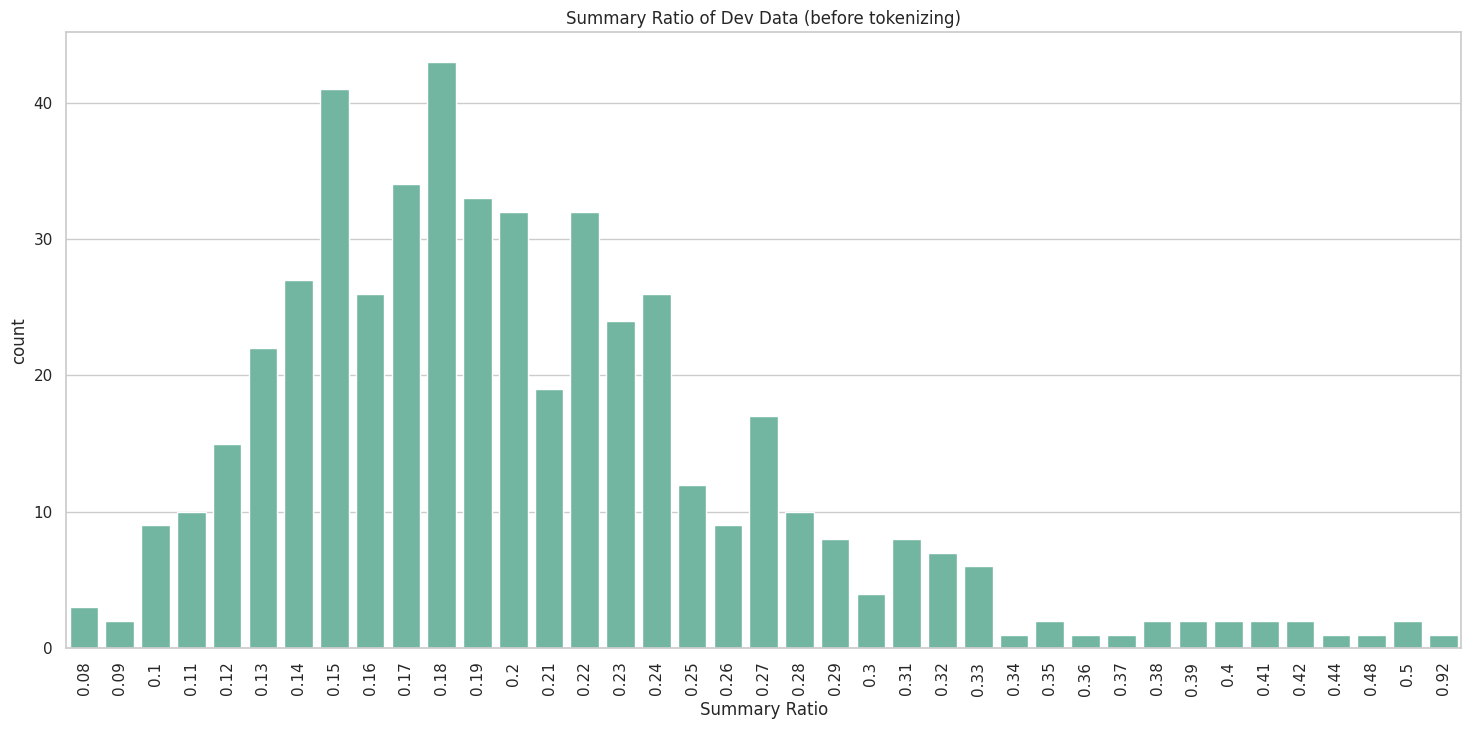

In [98]:
plt.figure(figsize=(18,8))
sns.countplot(data = dev_df, x = dev_df["summary_ratio"].round(2))
plt.xlabel("Summary Ratio")
plt.xticks(rotation=90)
plt.title("Summary Ratio of Dev Data (before tokenizing)")

In [99]:
pd.DataFrame(dev_df["summary_ratio"].describe())

,summary_ratio
count,499.000000
mean,0.203868
std,0.074597
min,0.077220
25%,0.153325
50%,0.191781
75%,0.235417
max,0.924242


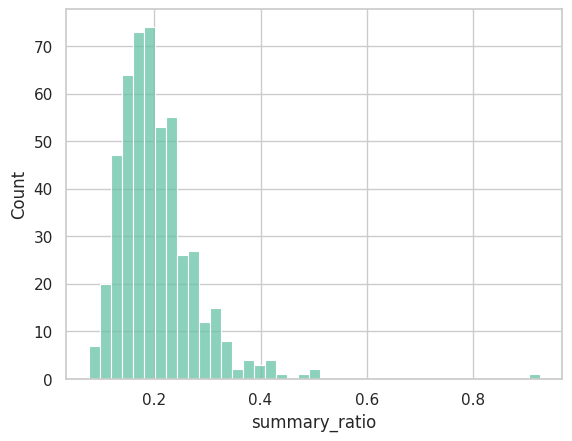

In [100]:
sns.histplot(dev_df["summary_ratio"])
plt.show()

In [101]:
dev_df[dev_df["summary_ratio"] > 0.5]

,fname,dialogue,summary,topic,dialogue_original_len,summary_original_len,topic_original_len,dialogue_len,summary_len,topic_len,summary_ratio
165,dev_165,#Person1#: 이 디자인으로 가슴 주머니가 하나만 달린 거 있나요?\n#Per...,#Person1#은 가슴 부분에 주머니가 하나 달린 특정 디자인을 사고 싶어하지만 ...,구매 실패,137,69,5,137,69,5,0.503650
381,dev_381,#Person1#: 제가 당신에게 상기시켜야 할 것은 당신의 아들이 때때로 수업에 ...,#Person1#은 #Person2#에게 #Person2#의 아들이 때때로 수업에 ...,수업에 늦음,132,122,6,132,122,6,0.924242


In [102]:
print(len(dev_df.loc[165, "dialogue"]))
print("-"*20)
print(dev_df.loc[165, "dialogue"])
print("-"*20)
print(len(dev_df.loc[165, "summary"]))
print("-"*20)
print(dev_df.loc[165, "summary"])

137
--------------------
#Person1#: 이 디자인으로 가슴 주머니가 하나만 달린 거 있나요?
#Person2#: 잠시만요. 디자인은 있는데 같은 색이 아니군요.
#Person1#: 아쉽네요. 제게는 너무 화려한 것 같아요. 감사합니다.
#Person2#: 천만에요.
--------------------
69
--------------------
#Person1#은 가슴 부분에 주머니가 하나 달린 특정 디자인을 사고 싶어하지만 #Person2#은 그런 물건이 없습니다.


In [103]:
print(len(dev_df.loc[381, "dialogue"]))
print("-"*20)
print(dev_df.loc[381, "dialogue"])
print("-"*20)
print(len(dev_df.loc[381, "summary"]))
print("-"*20)
print(dev_df.loc[381, "summary"])

132
--------------------
#Person1#: 제가 당신에게 상기시켜야 할 것은 당신의 아들이 때때로 수업에 25분 늦게 도착한다는 거에요.
#Person2#: 정말요? 하지만 그는 항상 수업 10분 전에 도착한다고 말해왔어요. 이번에는 반드시 벌을 줘야 겠네요.
--------------------
122
--------------------
#Person1#은 #Person2#에게 #Person2#의 아들이 때때로 수업에 늦는다고 말합니다. 그러자 #Person2#는 #Person2#의 아들이 거짓말을 하고 있다는 것을 깨닫고 그를 벌할 것이라고 말합니다.


##### dialogue

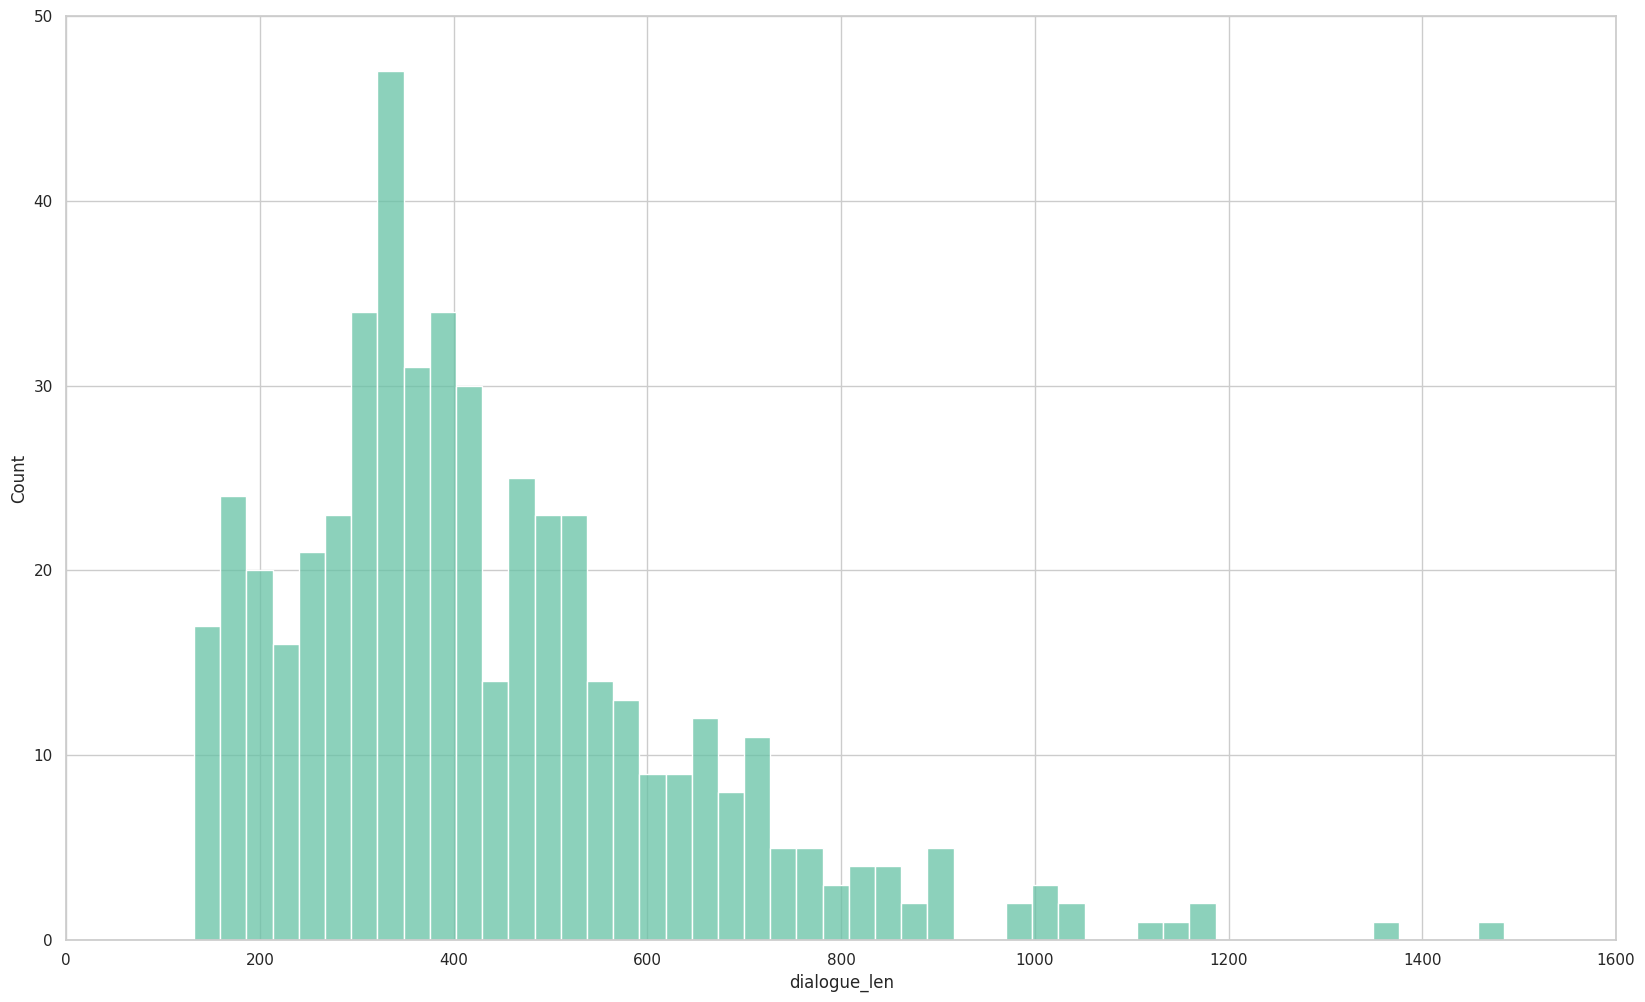

In [104]:
plt.figure(figsize=(20, 12))
sns.histplot(data = dev_df, x = dev_df["dialogue_len"], bins=50)
plt.xlim(0, 1600)
plt.ylim(0, 50)
plt.show()

In [105]:
pd.DataFrame(dev_df["dialogue_len"].describe().round(2))

,dialogue_len
count,499.00
mean,432.51
std,206.05
min,132.00
25%,299.00
50%,391.00
75%,526.00
max,1484.00


In [106]:
len(dev_df[dev_df["dialogue_original_len"] != dev_df["dialogue_len"]])

26

In [107]:
len(dev_df[(dev_df["dialogue_original_len"] - dev_df["dialogue_len"]) == 1])

26

In [108]:
len(dev_df[(dev_df["dialogue_original_len"] - dev_df["dialogue_len"]) > 1])

0

##### summary

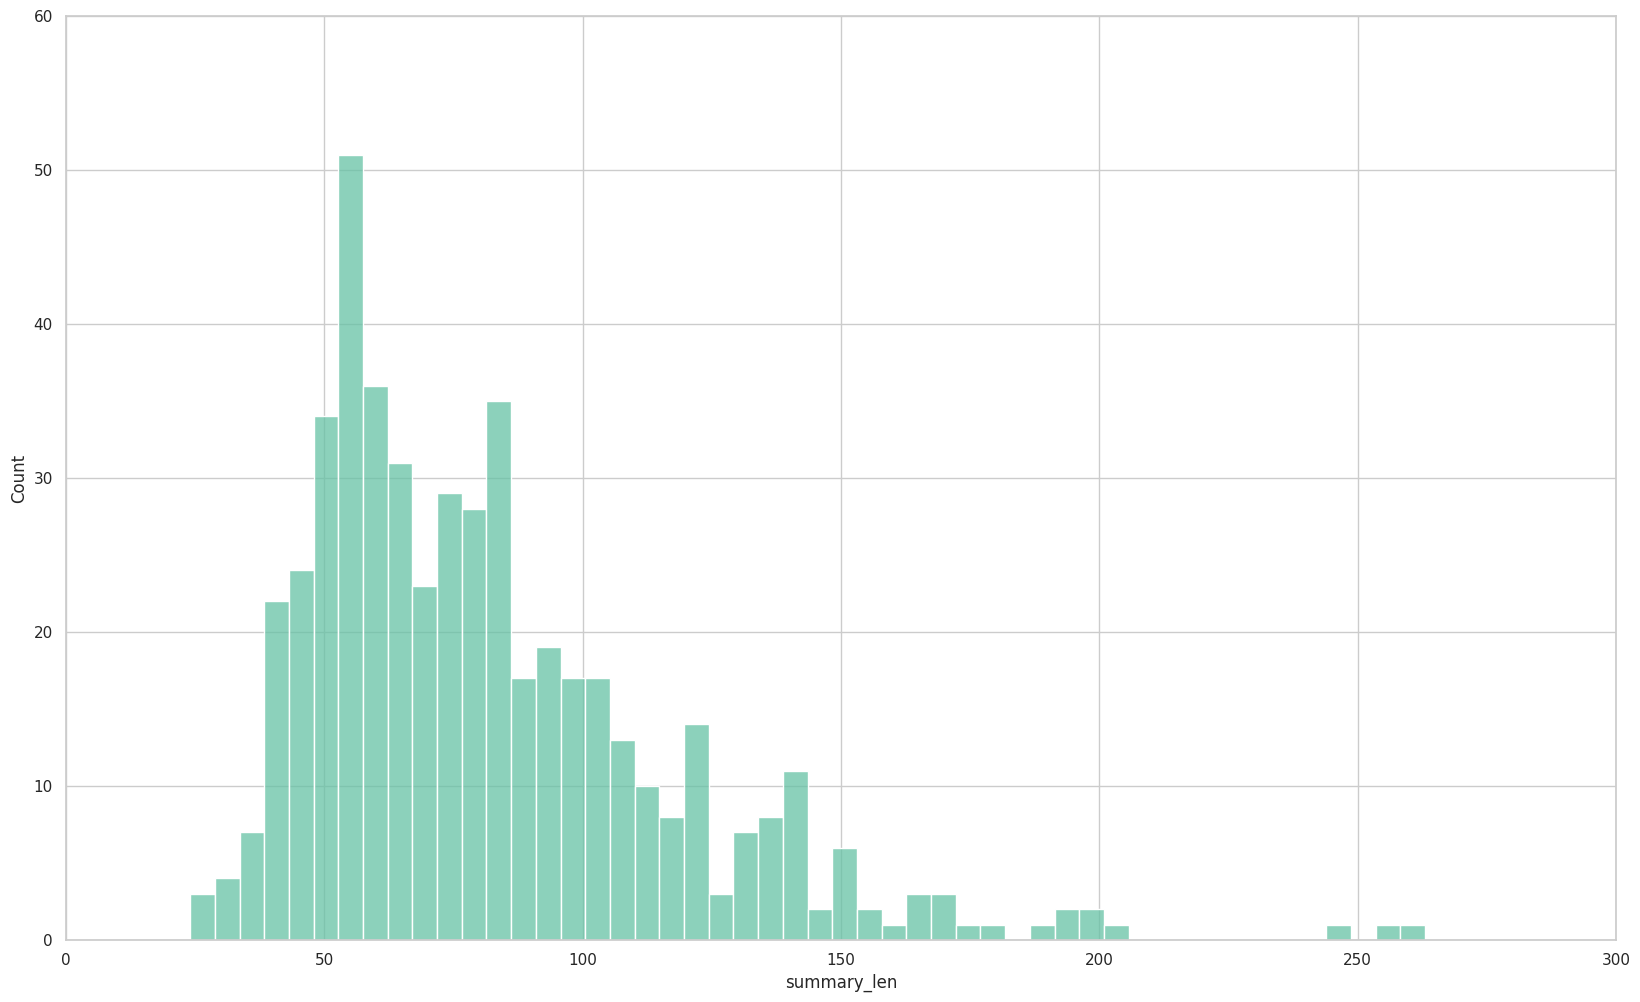

In [109]:
plt.figure(figsize=(20, 12))
sns.histplot(data = dev_df, x = dev_df["summary_len"], bins=50)
plt.xlim(0, 300)
plt.ylim(0, 60)
plt.show()

In [110]:
pd.DataFrame(dev_df["summary_len"].describe().round(2))

,summary_len
count,499.00
mean,81.70
std,35.88
min,24.00
25%,55.00
50%,74.00
75%,98.00
max,263.00


In [111]:
len(dev_df[dev_df["summary_original_len"] != dev_df["summary_len"]])

4

In [112]:
len(dev_df[(dev_df["summary_original_len"] - dev_df["summary_len"]) == 1])

4

In [113]:
len(dev_df[(dev_df["summary_original_len"] - dev_df["summary_len"]) > 1])

0

##### topic

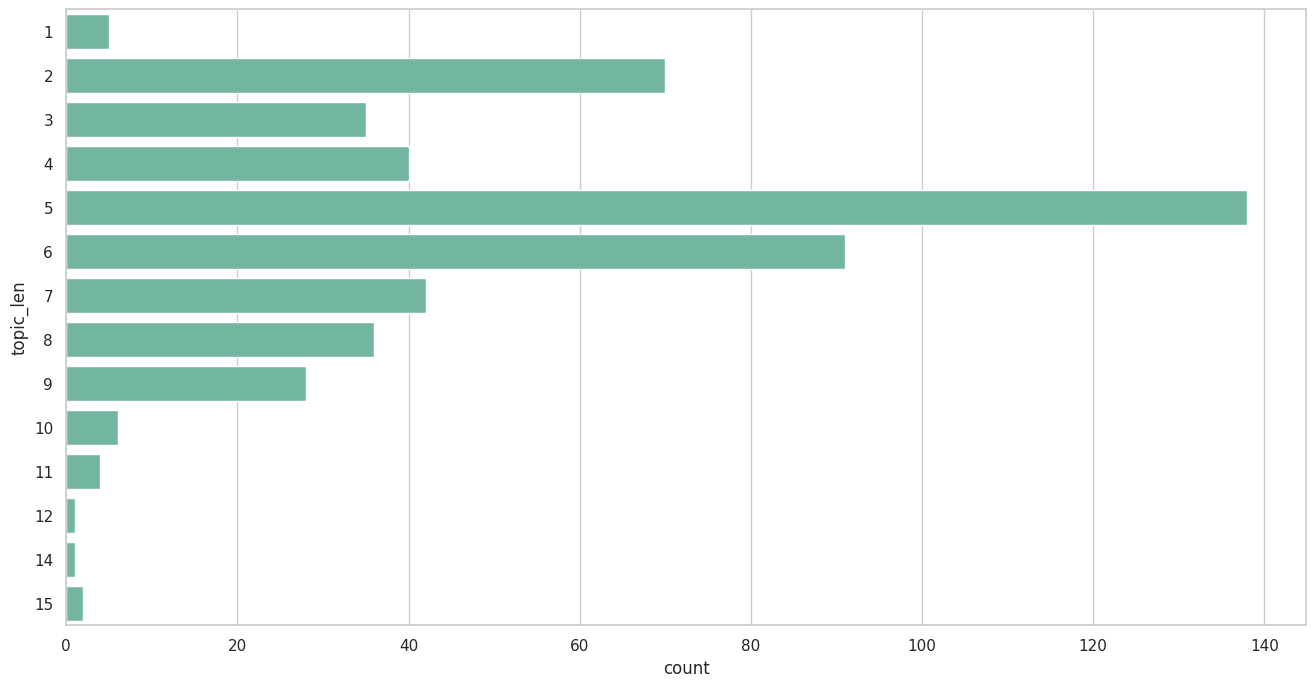

In [114]:
plt.figure(figsize=(16, 8))
sns.countplot(data = dev_df, y = dev_df["topic_len"])
plt.show()

In [115]:
len(dev_df[dev_df["topic_original_len"] != dev_df["topic_len"]])

0

##### tokenize

In [116]:
dev_df["dialogue_token"] = dev_df["dialogue"].apply(lambda x : tokenizer(x)["input_ids"])
dev_df["summary_token"] = dev_df["summary"].apply(lambda x : tokenizer(x)["input_ids"])
dev_df["dialogue_token_len"] = dev_df["dialogue_token"].apply(lambda x : len(x))
dev_df["summary_token_len"] = dev_df["summary_token"].apply(lambda x : len(x))
dev_df["summary_ratio_token"] = dev_df["summary_token_len"] / dev_df["dialogue_token_len"]

In [117]:
pd.DataFrame(dev_df["summary_ratio_token"].describe())

,summary_ratio_token
count,499.000000
mean,0.197820
std,0.067478
min,0.077869
25%,0.155896
50%,0.188312
75%,0.227437
max,0.854167


Text(0.5, 1.0, 'Summary Ratio of Dev Data (after tokenizing)')

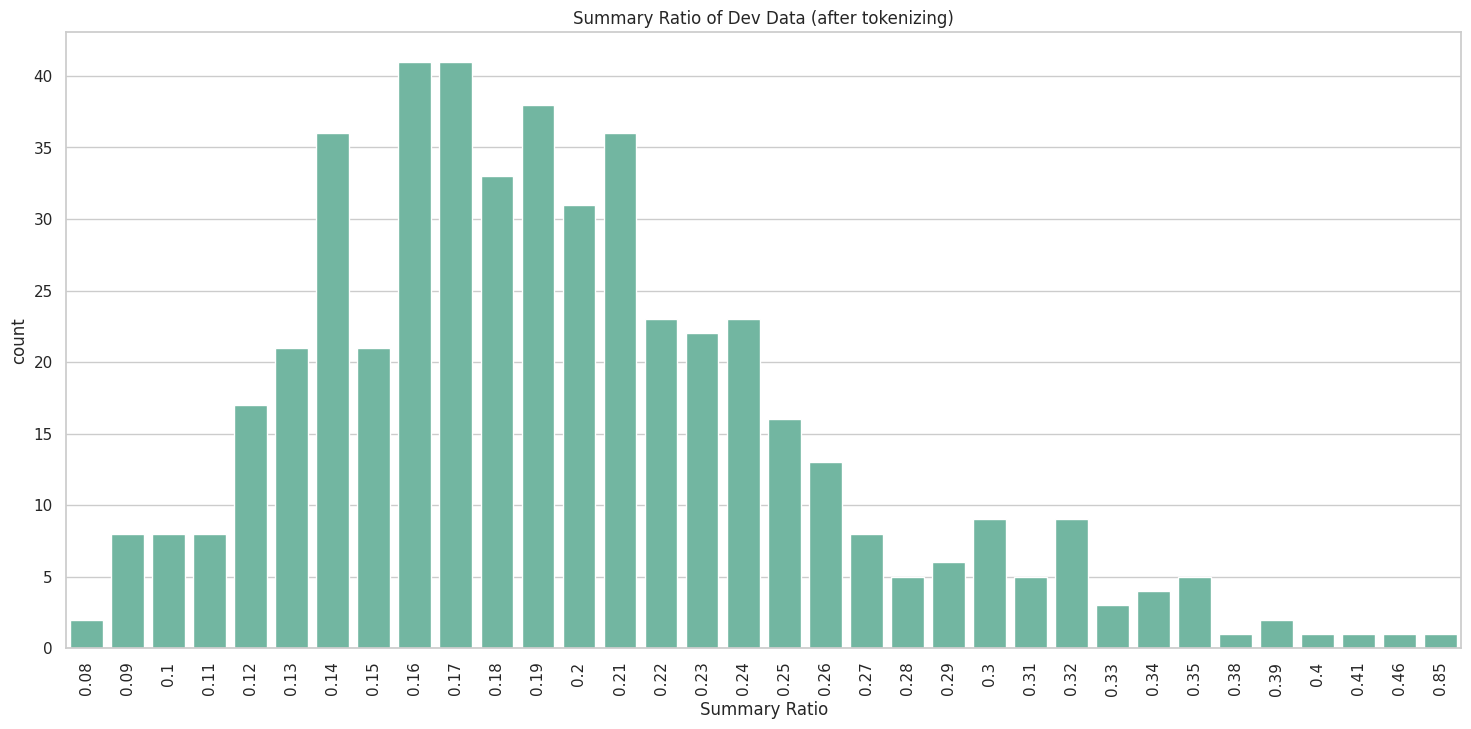

In [118]:
plt.figure(figsize=(18,8))
sns.countplot(data = dev_df, x = dev_df["summary_ratio_token"].round(2))
plt.xlabel("Summary Ratio")
plt.xticks(rotation=90)
plt.title("Summary Ratio of Dev Data (after tokenizing)")

In [119]:
dev_df[dev_df["summary_ratio_token"] > 0.5]

,fname,dialogue,summary,topic,dialogue_original_len,summary_original_len,topic_original_len,dialogue_len,summary_len,topic_len,summary_ratio,dialogue_token,summary_token,dialogue_token_len,summary_token_len,summary_ratio_token
381,dev_381,#Person1#: 제가 당신에게 상기시켜야 할 것은 당신의 아들이 때때로 수업에 ...,#Person1#은 #Person2#에게 #Person2#의 아들이 때때로 수업에 ...,수업에 늦음,132,122,6,132,122,6,0.924242,"[30015, 14987, 15995, 15564, 14120, 29090, 250...","[30015, 14806, 1700, 30014, 1700, 14120, 1700,...",48,41,0.854167


##### special tokens

In [120]:
dev_df['special_tokens_d'] = dev_df['dialogue'].apply(lambda x: re.findall(pattern, x))
dev_df['special_tokens_d_len'] = dev_df['special_tokens_d'].apply(lambda x: len(x))
dev_df['special_tokens_d_uni'] = dev_df['special_tokens_d'].apply(lambda x: list(set(x)))
dev_df['special_tokens_d_uni_len'] = dev_df['special_tokens_d_uni'].apply(lambda x : len(x))

dev_df['special_tokens_s'] = dev_df['summary'].apply(lambda x: re.findall(pattern, x))
dev_df['special_tokens_s_len'] = dev_df['special_tokens_s'].apply(lambda x: len(x))
dev_df['special_tokens_s_uni'] = dev_df['special_tokens_s'].apply(lambda x: list(set(x)))
dev_df['special_tokens_s_uni_len'] = dev_df['special_tokens_s_uni'].apply(lambda x : len(x))

Text(0.5, 1.0, 'Nunique of Special Tokens in Dev Dialogue')

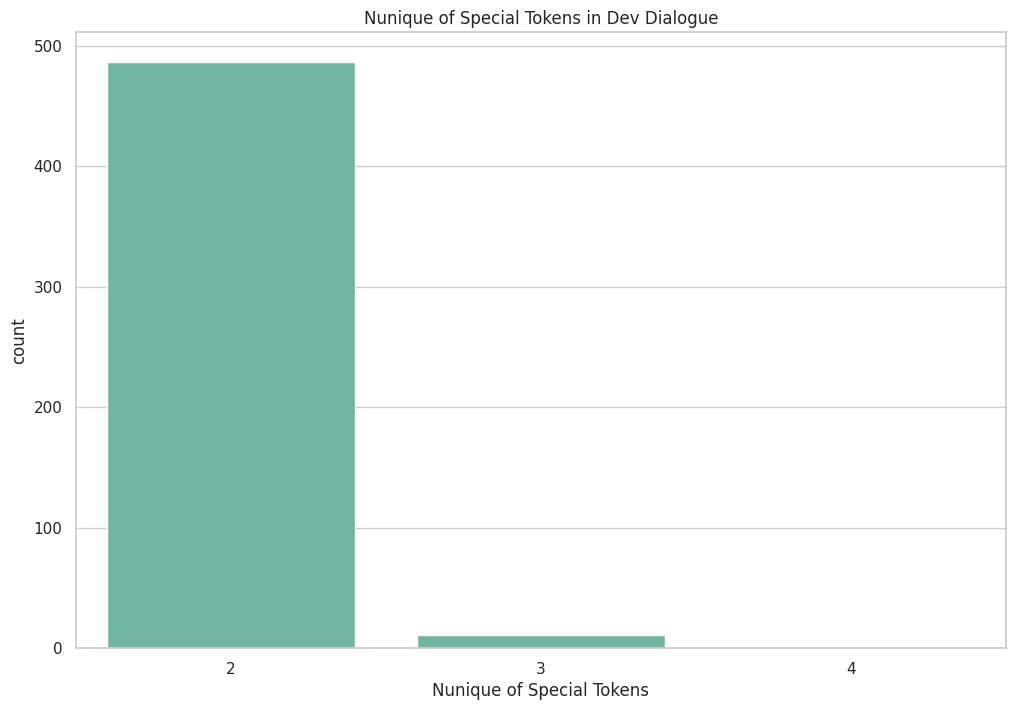

In [121]:
plt.figure(figsize=(12,8))
sns.countplot(data = dev_df, x = 'special_tokens_d_uni_len')
plt.xlabel("Nunique of Special Tokens")
plt.title("Nunique of Special Tokens in Dev Dialogue")

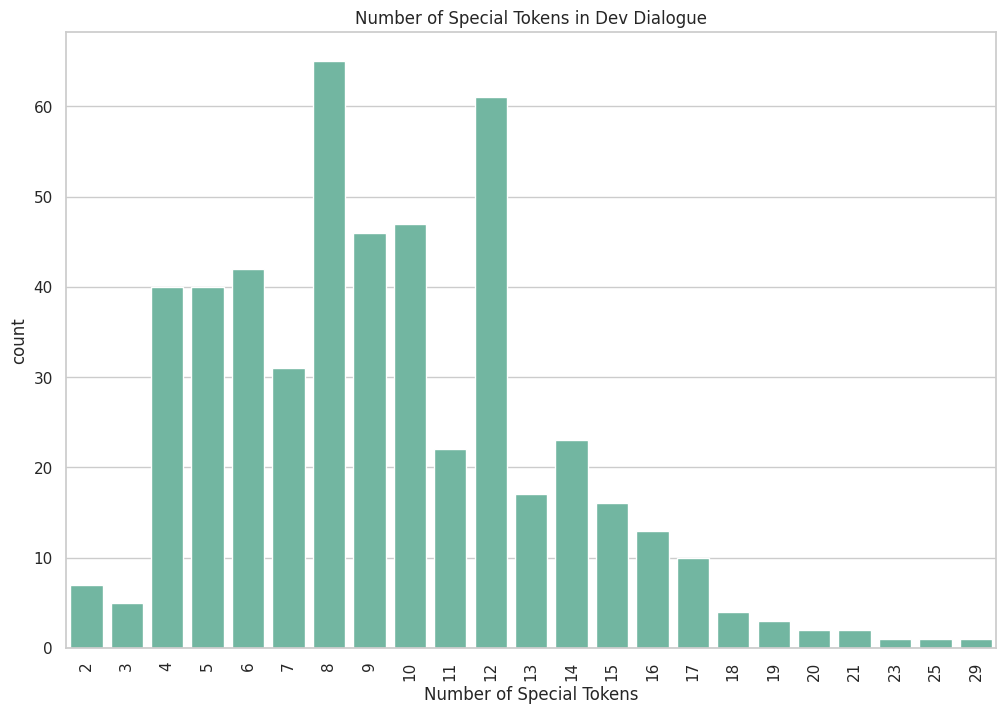

In [122]:
plt.figure(figsize=(12,8))
sns.countplot(data = dev_df, x = 'special_tokens_d_len')
plt.xlabel("Number of Special Tokens")
plt.title("Number of Special Tokens in Dev Dialogue")
plt.xticks(rotation=90)
plt.show()

In [123]:
pd.DataFrame(dev_df['special_tokens_d_uni_len'].value_counts().sort_index())

,count
special_tokens_d_uni_len,
2,487
3,11
4,1


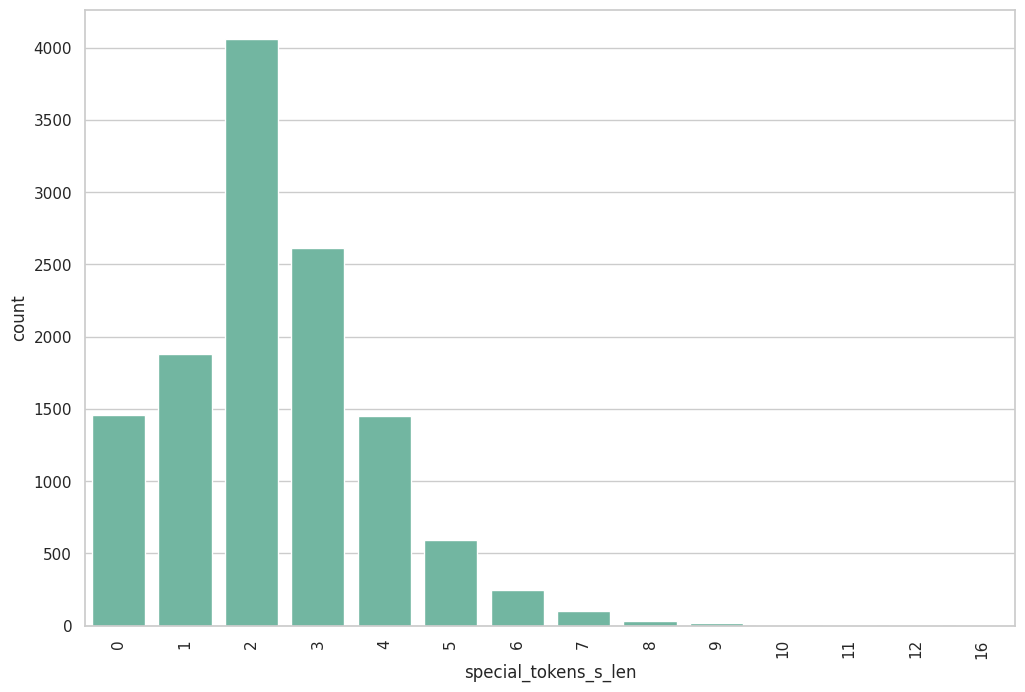

In [124]:
plt.figure(figsize=(12,8))
sns.countplot(data = train_df, x = 'special_tokens_s_len')
plt.xticks(rotation=90)
plt.show()

#### test data

In [125]:
test_df["dialogue_original_len"] = test_df["dialogue"].apply(lambda x : len(x))

In [126]:
test_df["dialogue"] = test_df["dialogue"].apply(lambda x: x.strip())
test_df["dialogue_len"] = test_df["dialogue"].apply(lambda x : len(x))

In [127]:
pd.DataFrame(test_df.describe().round(2))

,dialogue_original_len,dialogue_len
count,499.00,499.00
mean,449.31,449.27
std,239.19,239.19
min,109.00,109.00
25%,289.00,289.00
50%,407.00,407.00
75%,559.00,559.00
max,2650.00,2650.00


In [128]:
len(test_df[test_df["dialogue_original_len"] != test_df["dialogue_len"]])

20

In [129]:
len(test_df[(test_df["dialogue_original_len"] - test_df["dialogue_len"]) == 1])

20

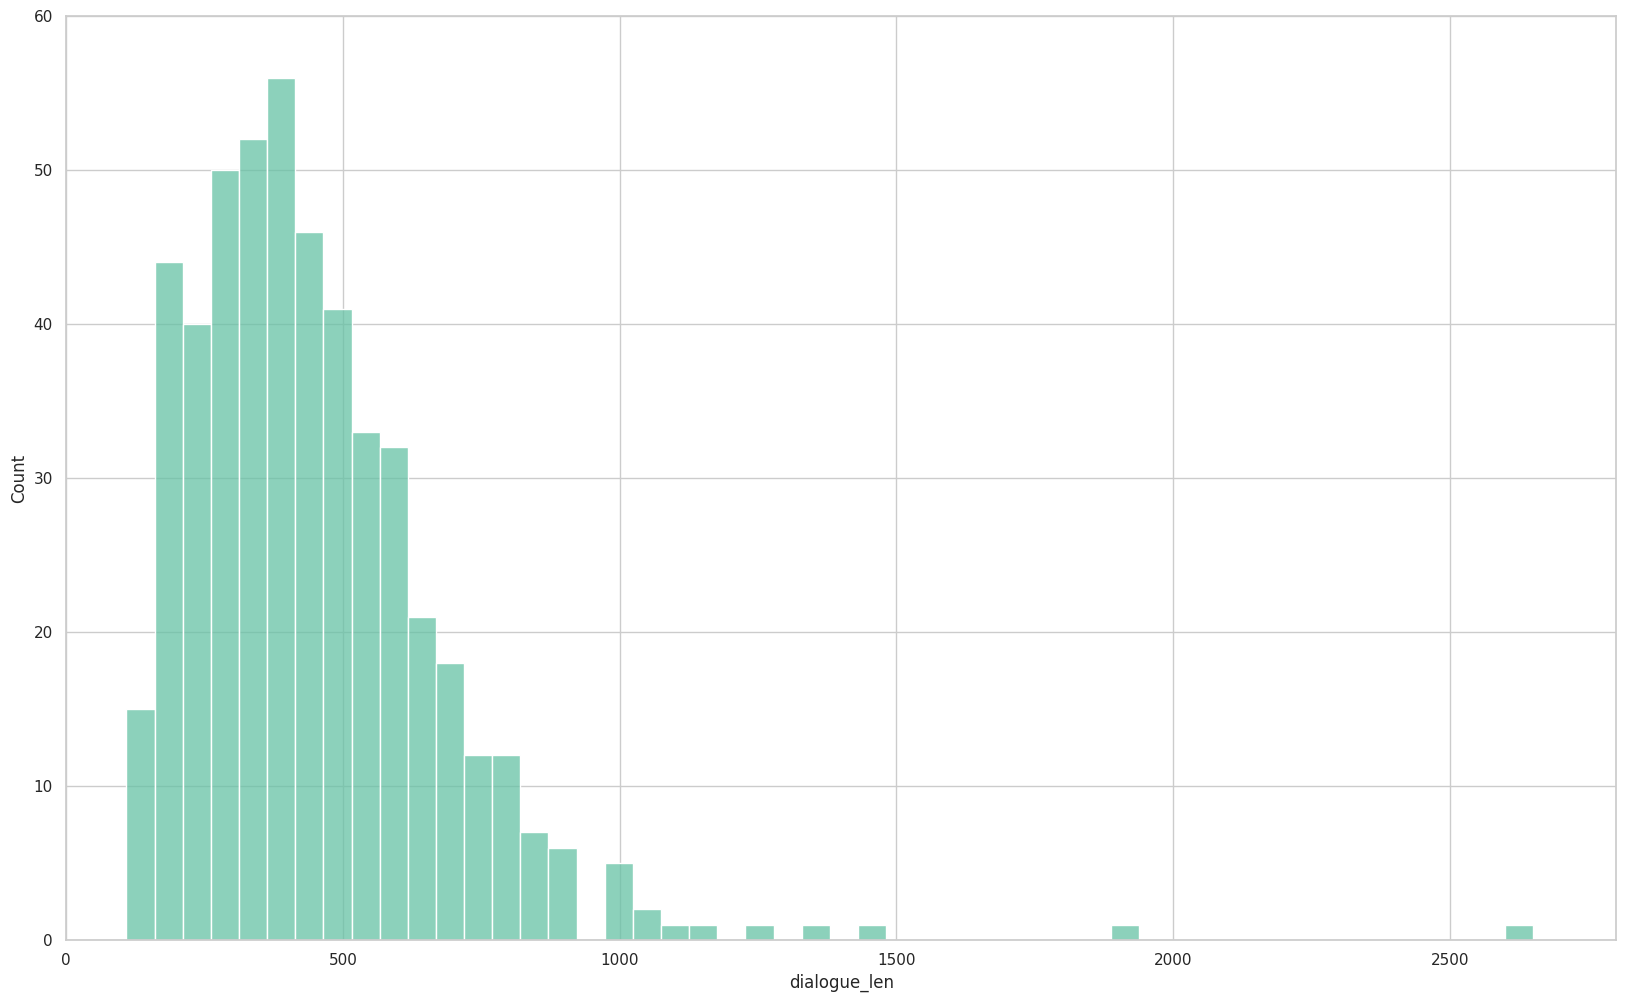

In [130]:
plt.figure(figsize=(20, 12))
sns.histplot(data = test_df, x = test_df["dialogue_len"], bins=50)
plt.xlim(0, 2800)
plt.ylim(0, 60)
plt.show()

In [131]:
test_df["dialogue_token"] = test_df["dialogue"].apply(lambda x : tokenizer(x)["input_ids"])

test_df["dialogue_token_len"] = test_df["dialogue_token"].apply(lambda x : len(x))


##### special tokens

In [132]:
test_df['special_tokens_d'] = test_df['dialogue'].apply(lambda x: re.findall(pattern, x))
test_df['special_tokens_d_len'] = test_df['special_tokens_d'].apply(lambda x: len(x))
test_df['special_tokens_d_uni'] = test_df['special_tokens_d'].apply(lambda x: list(set(x)))
test_df['special_tokens_d_uni_len'] = test_df['special_tokens_d_uni'].apply(lambda x : len(x))

In [133]:
pd.DataFrame(test_df['special_tokens_d_uni_len'].value_counts().sort_index())

,count
special_tokens_d_uni_len,
2,488
3,11


Text(0.5, 1.0, 'Nunique of Special Tokens in Test Dialogue')

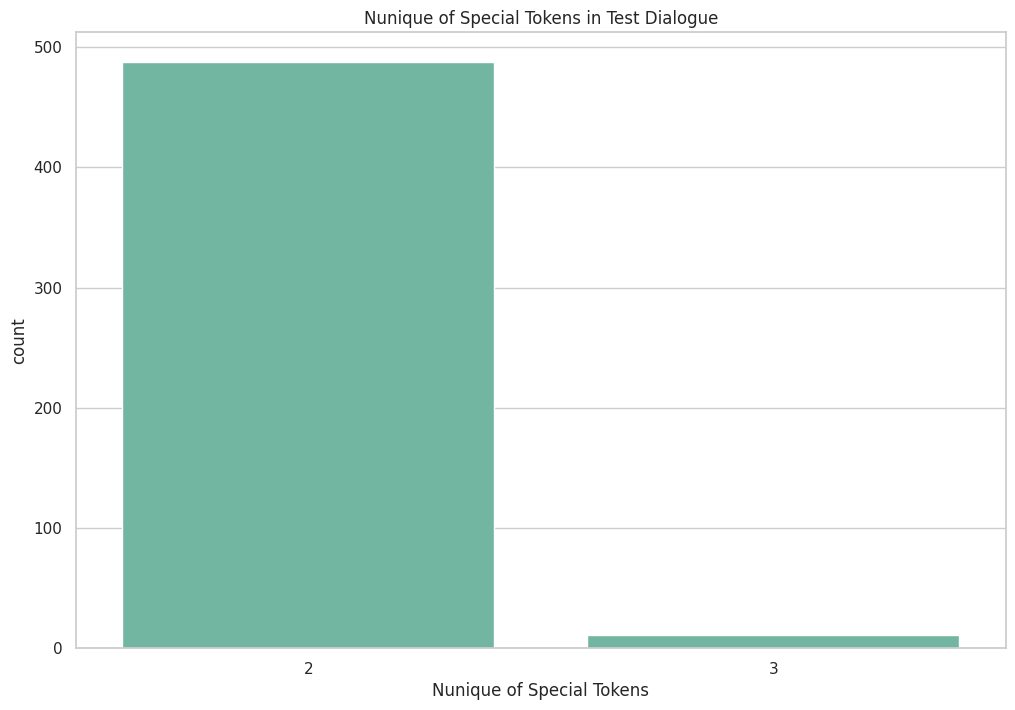

In [134]:
plt.figure(figsize=(12,8))
sns.countplot(data = test_df, x = 'special_tokens_d_uni_len')
plt.xlabel("Nunique of Special Tokens")
plt.title("Nunique of Special Tokens in Test Dialogue")

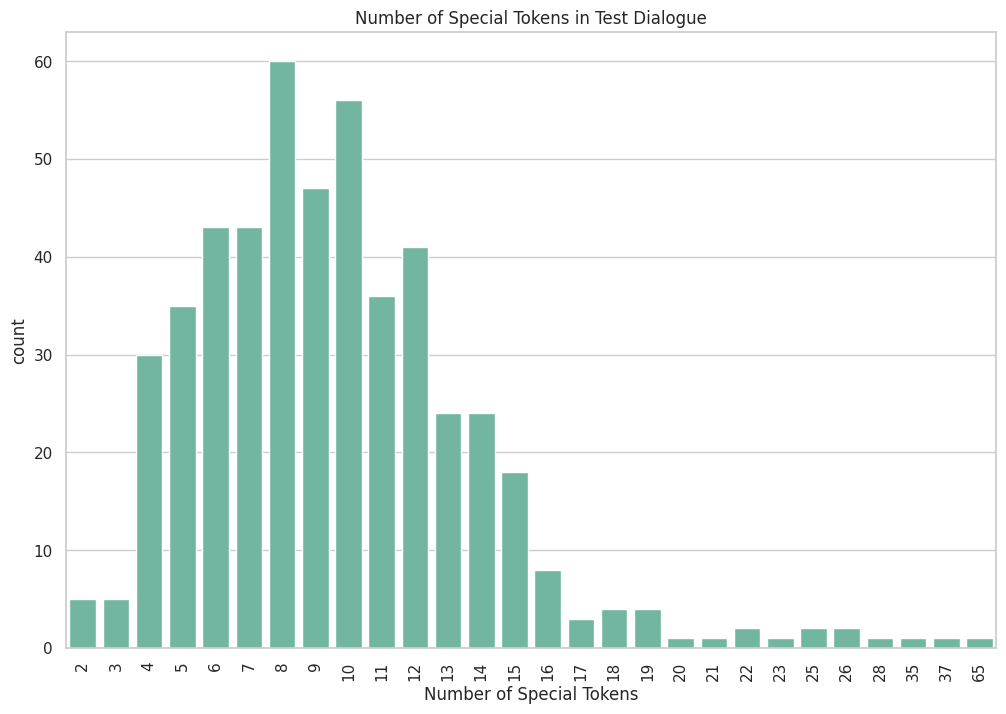

In [135]:
plt.figure(figsize=(12,8))
sns.countplot(data = test_df, x = 'special_tokens_d_len')
plt.xlabel("Number of Special Tokens")
plt.title("Number of Special Tokens in Test Dialogue")
plt.xticks(rotation=90)
plt.show()